In [649]:
from __future__ import print_function
import os.path
import pandas as pd
import gzip
import sys
import numpy as np

sys.path.insert(0, '..')

from src.CCLE_postp_function import *
from JKBio import terra
from JKBio.utils import helper as h
from JKBio.google import gcp
from JKBio import rna
from gsheets import Sheets
from taigapy import TaigaClient
import dalmatian as dm
from JKBio.google.google_sheet import dfToSheet
from biomart import BiomartServer
import io

from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import pearsonr,spearmanr

from bokeh.plotting import *
from bokeh.models import HoverTool
from collections import OrderedDict
from IPython.display import Image,display

%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython
tc = TaigaClient()
output_notebook()

my_id = '~/.client_secret.json'
mystorage_id = "~/.storage.json"
# do the first steps of https://medium.com/craftsmenltd/from-csv-to-google-sheet-using-python-ef097cb014f9
creds = '../.credentials.json'

sheets = Sheets.from_files(my_id, mystorage_id)
replace = {'T': 'Tumor', 'N': 'Normal', 'm': 'Unknown', 'L': 'Unknown'}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Loading BokehJS ...

In [399]:
samplesetname="21Q1"

workspace2="broad-firecloud-ccle/CCLE_DepMap_RNAseq"
workspace4="broad-genomics-delivery/Cancer_Cell_Line_Factory_CCLF_RNAseq"
workspace5="nci-mimoun-bi-org/CCLF_RNA_2_0"

workspace3="broad-genomics-delivery/CCLE_DepMap_RNAseq"
workspace1="broad-genomics-delivery/Getz_IBM_CellLines_RNASeqData"

workspace6="terra-broad-cancer-prod/CCLE_DepMap_RNAseq"
workspace7="terra-broad-cancer-prod/Getz_IBM_CellLines_RNASeqData"

refworkspace="broad-firecloud-ccle/DepMap_hg38_RNAseq"
source1="ibm"
source2="ccle"
source3="ccle"
source4="cclf"
source5="cclf"
source6="ccle"
source7="ibm"
release = samplesetname

refsheet_url = "https://docs.google.com/spreadsheets/d/1Pgb5fIClGnErEqzxpU7qqX6ULpGTDjvzWwDN8XUJKIY"
privacy_release_url = "https://docs.google.com/spreadsheets/d/115TUgA1t_mD32SnWAGpW9OKmJ2W5WYAOs3SuSdedpX4"

gencode = 'ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_35/gencode.v35.annotation.gff3.gz'

RNAmethods = ['']

maxage='2020-09-10'

# Generate sample set from new samples

In [131]:
extract_to_change = {'from_arxspan_id': 'participant',
}

In [170]:
#wm1 = dm.WorkspaceManager(workspace1)
#wm2 = dm.WorkspaceManager(workspace2)
#wm3 = dm.WorkspaceManager(workspace3)
#wm4 = dm.WorkspaceManager(workspace4)
#wm5 = dm.WorkspaceManager(workspace5)
wm6 = dm.WorkspaceManager(workspace6)
wm7 = dm.WorkspaceManager(workspace7)
refwm = dm.WorkspaceManager(refworkspace).disable_hound()

In [164]:
ccle_refsamples = sheets.get(refsheet_url).sheets[0].to_frame().set_index('cds_sample_id')

In [165]:
# we will be missing "primary disease","sm_id", "cellosaurus_id", "gender, "age", "primary_site", "primary_disease", "subtype", "subsubtype", "origin", "comments"
#when SMid: match==
samples, pairs, noarxspan = GetNewCellLinesFromWorkspaces(refworkspace, stype='rna', maxage=maxage, refurl=refsheet_url, wmfroms = [workspace6, workspace7], sources=[source6, source7], match=['ACH-','CDS-'], participantslicepos=10, accept_unknowntypes=True, extract=extract_to_change, recomputedate=True)

refsamples is overrided by a refurl
Getting sample infos...

The shape of the sample tsv from <dalmatian.wmanager.WorkspaceManager terra-broad-cancer-prod/CCLE_DepMap_RNAseq>: (152, 233)
Identifying any true duplicates by checking file hashes (this runs for each data source)...
This step can take a while as we need to use gsutil to check the size of each potential duplicate...
listing files in gs
These 11 bam file path do not exist: {'gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/CCLE_DepMap_RNAseq_July_Dec_2018_RP_1420/G136933/NA/RD_P3F__14_1/v2/RD_P3F__14_1.bam', 'gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/CCLE_DepMap_RNAseq_July_Dec_2018_RP_1420/G136933/NA/RD_P3F__9_1/v2/RD_P3F__9_1.bam', 'gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/CCLE_DepMap_RNAseq_July_Dec_2018_RP_1420/G136933/NA/MSKB9_1/v2/MSKB9_1.bam', 'gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/CCLE_DepMap_RNAseq_July_Dec_2018_RP_1420/G136933/NA/RH41_1/v2/RH41_1.bam', 'gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/CCLE_Dep

/home/jeremie/ccle_processing/src/CCLE_postp_function.py:279: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples[extract['hash']] = [gcp.extractHash(val) for val in gcp.lsFiles(samples[extract["bam"]].tolist(), "-L", 200)]


listing files in gs


/home/jeremie/ccle_processing/src/CCLE_postp_function.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples[extract['size']] = [gcp.extractSize(i)[1] for i in lis]
/home/jeremie/ccle_processing/src/CCLE_postp_function.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples[extract['update_time']] = [gcp.extractTime(i) for i in lis]


too small size, removing sample: PEDS172
too small size, removing sample: OUMS-27
listing files in gs
listing files in gs
we found and removed 0 samples which did not match our id names: ['ACH-', 'CDS-']
found 116 likely replicate
listing files in gs
Len of samples before removal: 130
Dups from this workspace has len 115:
 ['gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/DepMap_CellLine_RNAseq_Sept2019/RP-1561/RNA/FARAGE/v1/FARAGE.bam', 'gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/CCLE_DepMap_RNAseq_July_Dec_2018/RP-1561/RNA/SNU638/v1/SNU638.bam', 'gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/DepMap_CellLine_RNAseq_Feb2020/RP-1561/RNA/ULA/v1/ULA.bam', 'gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/DepMap_CellLine_RNAseq_June2019/RP-1561/RNA/RPE1SS6/v3/RPE1SS6.bam', 'gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/CCLE_DepMap_RNAseq_July_Dec_2018/RP-1561/RNA/SSP25/v2/SSP25.bam', 'gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/DepMap_CellLine_RNAseq_March2020/RP-1561/RNA/COLO824/v1/COLO824.bam'


The shape of the sample tsv from <dalmatian.wmanager.WorkspaceManager terra-broad-cancer-prod/Getz_IBM_CellLines_RNASeqData>: (222, 243)
Identifying any true duplicates by checking file hashes (this runs for each data source)...
This step can take a while as we need to use gsutil to check the size of each potential duplicate...
listing files in gs
These 12 bam file path do not exist: {'gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/Getz_IBM_DMX_CellLines_10samples_Truseq_100M_12082018/RP-1420/RNA/SNU1544/v1/SNU1544.bam', 'gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/Getz_IBM_DMX_CellLines_10samples_Truseq_100M_12082018/RP-1420/RNA/KML1/v1/KML1.bam', 'gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/Getz_IBM_DMX_CellLines_10samples_Truseq_100M_12082018/RP-1420/RNA/UHO1/v1/UHO1.bam', 'gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/Getz_IBM_DMX_CellLines_10samples_Truseq_100M_12082018/RP-1420/RNA/HT144SKINFV1/v1/HT144SKINFV1.bam', 'gs://fc-df687511-3eca-46f7-ba2f-202a27f7373f/Getz_IBM_DMX_CellLi

removed: 1 samples from size alone (too similar to a replicate)
removed: 0 samples with duplicat PDO ids 
removed: 0 samples that have not changed since last time (likely duplicate having been removed)


In [166]:
samples

,internal_bam_filepath,internal_bai_filepath,stripped_cell_line_name,arxspan_id,sequencing_date,participant_id,crc32c_hash,size,PDO,update_time,datatype,version
sample_id,,,,,,,,,,,,
CDS-yYeDem,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,CCLFPEDS0009T,ACH-001429,737654,PT-gpiijlSj,Poshhw==,5472926405,PDO-21569,2020-11-30,rna,2
CDS-OT217E,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,CHP134,ACH-001338,737532,PT-sqRdd0QF,Q16cnw==,6002304811,PDO-21298,2020-10-20,rna,1
CDS-a8BCnW,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,ICC18,ACH-001996,737532,PT-fZWks7bl,UCS4ZA==,5991484536,PDO-21298,2020-10-20,rna,1
CDS-zeFugQ,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,IMSM2,ACH-002707,737654,PT-KQHkzAJs,/lmAuw==,4014909588,PDO-21569,2020-11-30,rna,1
CDS-GOI63U,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,LU165,ACH-002077,737532,PT-3za4R2YQ,Hf83Bg==,5377989057,PDO-21298,2020-10-20,rna,1
CDS-ldvG6N,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,MEGA2,ACH-001553,737532,PT-SMrpbPt7,BQIicg==,5217506827,PDO-21298,2020-10-20,rna,1
CDS-LFK9QA,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,MM28,ACH-002013,737532,PT-ws3gMJ8I,fpKmsQ==,5305733170,PDO-21298,2020-10-20,rna,1
CDS-SdYhEt,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,MMAC,ACH-002084,737532,PT-ViFHoQt0,7IOo/g==,5952472821,PDO-21298,2020-10-20,rna,1
CDS-gyyVs5,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,ONE58,ACH-001992,737532,PT-77bcwWNt,YVR6Yg==,6748822799,PDO-21298,2020-10-20,rna,1


In [167]:
noarxspan

,internal_bam_filepath,internal_bai_filepath,stripped_cell_line_name,arxspan_id,sequencing_date,participant_id,crc32c_hash,size,PDO,update_time
sample_id,,,,,,,,,,
CDS-ENBZoP,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,EB2,EB1_EB2,737532,PT-4Trzwz7x,SszmCg==,5670639002,PDO-21298,2020-10-20
CDS-AjraFI,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,OUMS-27,OUMS-27,737654,PT-A4cySzi4,7OzbmA==,4287538026,"PDO-21298,PDO-21579",2020-11-30


In [150]:
noarxspan = retrieveFromCellLineName(noarxspan, ccle_refsamples, datatype='rna', arxspan_id="arxspan_id", depmappvlink = "https://docs.google.com/spreadsheets/d/1uqCOos-T9EMQU7y2ZUw4Nm84opU5fIT1y7jet1vnScE")

we found and removed 0 samples which did not match our id names: ['ACH', 'CDS']
found 0 likely replicate
listing files in gs
Len of samples before removal: 2
Dups from this workspace has len 0:
 []
Len of samples after removal: 2


In [151]:
samples = pd.concat([samples, noarxspan[noarxspan.arxspan_id!='0']], sort=False)

In [152]:
noarxspan = noarxspan[noarxspan.arxspan_id=='0']

In [153]:
samples = assessAllSamples(samples, ccle_refsamples, stype='rna', rename={}, extract={})

we had 0 duplicates in the release buckets


In [154]:
samples

,internal_bam_filepath,internal_bai_filepath,stripped_cell_line_name,arxspan_id,sequencing_date,participant_id,crc32c_hash,size,PDO,update_time,datatype,version
sample_id,,,,,,,,,,,,
CDS-EDhsHu,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,CCLFPEDS0009T,ACH-001429,737654,PT-gpiijlSj,Poshhw==,5472926405,PDO-21569,2020-11-30,rna,2
CDS-wstWJ8,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,CHP134,ACH-001338,737532,PT-sqRdd0QF,Q16cnw==,6002304811,PDO-21298,2020-10-20,rna,1
CDS-XUhaMo,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,ICC18,ACH-001996,737532,PT-8lfkZuoY,UCS4ZA==,5991484536,PDO-21298,2020-10-20,rna,1
CDS-bkeKLO,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,IMSM2,ACH-002707,737654,PT-wXsJKxYa,/lmAuw==,4014909588,PDO-21569,2020-11-30,rna,1
CDS-im5o3P,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,LU165,ACH-002077,737532,PT-3za4R2YQ,Hf83Bg==,5377989057,PDO-21298,2020-10-20,rna,1
CDS-Kc9pSO,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,MEGA2,ACH-001553,737532,PT-SMrpbPt7,BQIicg==,5217506827,PDO-21298,2020-10-20,rna,1
CDS-pbrcWz,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,MM28,ACH-002013,737532,PT-ws3gMJ8I,fpKmsQ==,5305733170,PDO-21298,2020-10-20,rna,1
CDS-GXi95L,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,MMAC,ACH-002084,737532,PT-ZxjGSuys,7IOo/g==,5952472821,PDO-21298,2020-10-20,rna,1
CDS-MJR6f7,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,ONE58,ACH-001992,737532,PT-oP9xuhLP,YVR6Yg==,6748822799,PDO-21298,2020-10-20,rna,1


## getting the addtional data and writing it here in the right order 'as shown above'
- use the stripped_cell_line_name to find the samples on https://docs.google.com/spreadsheets/d/1uqCOos-T9EMQU7y2ZUw4Nm84opU5fIT1y7jet1vnScE/edit#gid=356471436. 
- Make sure that we don't have duplicate cell lines in there. Otherwise, use the duplicate renaming function
- copy Primary Site, Primary Disease, Subtype, Comments, Disease Sub-subtype, if they exist. (sometimes subtype and subsubtype are the same.. don't use subsubtype then.
- look for the cell line in cellosaurus, you might need to use one of the aliases given in master depmap pv..
- copy  cellosaurus_id gender age info or write 'U' if they don't exist. 'can be a number or {Embryonic, Children, Adult, Fetus, U} 
- check that it does not say this cell line is not a duplicate from another cell line
- check that if it says this cell line is derived/children/father/samepatient from other cell lines, and that if we have any of the other cell lines, that the patient id is changed to be the same one for all (be sure that you are updating everywhere these patient ids are used)

In [155]:
samples, notfound = updateFromTracker(samples, ccle_refsamples)

In [156]:
noarxspan

,internal_bam_filepath,internal_bai_filepath,stripped_cell_line_name,arxspan_id,sequencing_date,participant_id,crc32c_hash,size,PDO,update_time
sample_id,,,,,,,,,,


In [157]:
noarxspan.sort_values(by = 'stripped_cell_line_name').to_csv('temp/noarxspan_rna_' + release + '.csv')
samples.loc[notfound].to_csv('temp/norfound_rna_'+release+'.csv')
samples.to_csv('temp/new_rna_'+release+'.csv')

In [158]:
# for these samples I will need to check and manually add the data in the list 
samples.loc[notfound]

,internal_bam_filepath,internal_bai_filepath,stripped_cell_line_name,arxspan_id,sequencing_date,participant_id,crc32c_hash,size,PDO,update_time,...,age,primary_site,subtype,subsubtype,origin,parent_cell_line,matched_normal,comments,mediatype,condition
sample_id,,,,,,,,,,,,,,,,,,,,,
CDS-XUhaMo,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,ICC18,ACH-001996,737532,PT-8lfkZuoY,UCS4ZA==,5991484536,PDO-21298,2020-10-20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CDS-bkeKLO,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,IMSM2,ACH-002707,737654,PT-wXsJKxYa,/lmAuw==,4014909588,PDO-21569,2020-11-30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CDS-GXi95L,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,MMAC,ACH-002084,737532,PT-ZxjGSuys,7IOo/g==,5952472821,PDO-21298,2020-10-20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CDS-MJR6f7,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,ONE58,ACH-001992,737532,PT-oP9xuhLP,YVR6Yg==,6748822799,PDO-21298,2020-10-20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CDS-L3vG6c,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,PEO6,ACH-001633,737532,PT-Z8bsyLJ1,TXgxVg==,5762866404,PDO-21298,2020-10-20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CDS-Z8VsdD,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,T3M11,ACH-002034,737532,PT-BRxq0Dex,bUgW5w==,5564516582,PDO-21298,2020-10-20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CDS-4B4Vxx,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,TN2,ACH-002080,737532,PT-7JA1hOGp,N9rgng==,4389139652,PDO-21298,2020-10-20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CDS-a4oKRY,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,gs://fc-637ec010-3452-4780-ae41-7811feb6aa2b/D...,WM3772F,ACH-002687,737654,PT-8CVFW2cW,9jBKvA==,4993880113,PDO-21569,2020-11-30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [159]:
toupdate = {
"primary_disease":["Bile Duct Cancer","Leukemia","Skin Cancer",'Lung Cancer','Ovarian Cancer',"Lung Cancer",'Neuroblastoma','Eye Cancer'],
"cellosaurus_id":["","","CVCL_5951",'CVCL_2671','CVCL_2691','CVCL_8066','CVCL_5602','CVCL_0B81'],
"age":["U",'U','39','58','U','U','U','U'],
"primary_site":["biliary_tract", "bone_marrow", "ascites", "pleural_effusion", 'ascites','lung','autonomic_ganglia','eye'],
"subtype":["Cholangiocarcinoma",'AML','Melanoma','Mesothelioma','Cystadenocarcinoma','SCLC','neuroblastoma','Uveal Melanoma'],
"subsubtype":["intrahepatic","M2","",'','','','adrenal',''],
"origin":["biliary_tract","bone_marrow","skin",'lung','ovary','lung','peripheral_nervous_system',''],
"sex":["U","F","F",'M','F','M','M','F'],
"parent_cell_line":['',"","","","",'','',''],
"matched_normal":['',"","","","",'','',''],
"comments":["derived from MG119; Received from Academic lab (Bardeesy, MGH)","Acute Myelogenous Leukemia (AML), M2 (Myeloblastic), Received from Academic lab (Roti, Univ of Parma)",'Human melanoma, spindle-shaped. Said DOPA (+). Cell growth is slow.','','Human ovarian cancer; oestrogen receptor positive','Lung small cell carcinoma producing insulin-like growth factor II. Cell growth is slow.','Human cell line derived from neuroblastoma of adrenal gland. TKG0278 (Deposited from Tohoku Univ.).', 'Received from Tak Ito'],
"mediatype":["Adherent, RPMI + 10% FBS",'Suspension, RPMI+10%FBS+1%P/S+ 1%Glu',"Adherent, RPMI1640+10%FBS",'Adherent, RPMI 1640 (with 2mM L-Glutamine + 25mM HEPES) + 5% FBS',"Adherent, RPMI 1640 + 10% FBS + 2mM Glutamine + 2mM Sodium Pyruvate",'HamF10+10%FBS','Adherent, RPMI1640+10%FBS','Adherent	RPMI1640 with 20% heat inactivated fetal bovine serum (FBS)'],
"condition":['',"","",'','','','',''],
'stripped_cell_line_name':['ICC18','IMSM2',"MMAC",'ONE58','PEO6','T3M11','TN2','WM3772F'],
"participant_id":['PT-OFTqDW5x','PT-cOesajdE',"PT-Xh2QumBq",'PT-RtlUmFsX','PT-x99zIefg','PT-iDbz8mvS','PT-H9hIWgeO','PT-flI1kAwI']
}
pd.DataFrame(toupdate)

,primary_disease,cellosaurus_id,age,primary_site,subtype,subsubtype,origin,sex,parent_cell_line,matched_normal,comments,mediatype,condition,stripped_cell_line_name,participant_id
0,Bile Duct Cancer,,U,biliary_tract,Cholangiocarcinoma,intrahepatic,biliary_tract,U,,,derived from MG119; Received from Academic lab...,"Adherent, RPMI + 10% FBS",,ICC18,PT-OFTqDW5x
1,Leukemia,,U,bone_marrow,AML,M2,bone_marrow,F,,,"Acute Myelogenous Leukemia (AML), M2 (Myelobla...","Suspension, RPMI+10%FBS+1%P/S+ 1%Glu",,IMSM2,PT-cOesajdE
2,Skin Cancer,CVCL_5951,39,ascites,Melanoma,,skin,F,,,"Human melanoma, spindle-shaped. Said DOPA (+)....","Adherent, RPMI1640+10%FBS",,MMAC,PT-Xh2QumBq
3,Lung Cancer,CVCL_2671,58,pleural_effusion,Mesothelioma,,lung,M,,,,"Adherent, RPMI 1640 (with 2mM L-Glutamine + 25...",,ONE58,PT-RtlUmFsX
4,Ovarian Cancer,CVCL_2691,U,ascites,Cystadenocarcinoma,,ovary,F,,,Human ovarian cancer; oestrogen receptor positive,"Adherent, RPMI 1640 + 10% FBS + 2mM Glutamine ...",,PEO6,PT-x99zIefg
5,Lung Cancer,CVCL_8066,U,lung,SCLC,,lung,M,,,Lung small cell carcinoma producing insulin-li...,HamF10+10%FBS,,T3M11,PT-iDbz8mvS
6,Neuroblastoma,CVCL_5602,U,autonomic_ganglia,neuroblastoma,adrenal,peripheral_nervous_system,M,,,Human cell line derived from neuroblastoma of ...,"Adherent, RPMI1640+10%FBS",,TN2,PT-H9hIWgeO
7,Eye Cancer,CVCL_0B81,U,eye,Uveal Melanoma,,,F,,,Received from Tak Ito,Adherent\tRPMI1640 with 20% heat inactivated f...,,WM3772F,PT-flI1kAwI


In [160]:
# updating..
for k, v in toupdate.items():
    samples.loc[notfound,k] =v

In [192]:
# uploading to our bucket (now a new function)
samples = terra.changeToBucket(samples,'gs://cclebams/rna/', name_col= "index" , values=['internal_bam_filepath','internal_bai_filepath'], filetypes=['bam', 'bai'], catchdup=True, test=False)

,internal_bam_filepath,internal_bai_filepath,stripped_cell_line_name,arxspan_id,sequencing_date,participant_id,crc32c_hash,size,PDO,update_time,datatype,version
sample_id,,,,,,,,,,,,
CDS-yYeDem,gs://cclebams/rna/CDS-yYeDem.bam,gs://cclebams/rna/CDS-yYeDem.bai,CCLFPEDS0009T,ACH-001429,737654,PT-gpiijlSj,Poshhw==,5472926405,PDO-21569,2020-11-30,rna,2
CDS-OT217E,gs://cclebams/rna/CDS-OT217E.bam,gs://cclebams/rna/CDS-OT217E.bai,CHP134,ACH-001338,737532,PT-sqRdd0QF,Q16cnw==,6002304811,PDO-21298,2020-10-20,rna,1
CDS-a8BCnW,gs://cclebams/rna/CDS-a8BCnW.bam,gs://cclebams/rna/CDS-a8BCnW.bai,ICC18,ACH-001996,737532,PT-fZWks7bl,UCS4ZA==,5991484536,PDO-21298,2020-10-20,rna,1
CDS-zeFugQ,gs://cclebams/rna/CDS-zeFugQ.bam,gs://cclebams/rna/CDS-zeFugQ.bai,IMSM2,ACH-002707,737654,PT-KQHkzAJs,/lmAuw==,4014909588,PDO-21569,2020-11-30,rna,1
CDS-GOI63U,gs://cclebams/rna/CDS-GOI63U.bam,gs://cclebams/rna/CDS-GOI63U.bai,LU165,ACH-002077,737532,PT-3za4R2YQ,Hf83Bg==,5377989057,PDO-21298,2020-10-20,rna,1
CDS-ldvG6N,gs://cclebams/rna/CDS-ldvG6N.bam,gs://cclebams/rna/CDS-ldvG6N.bai,MEGA2,ACH-001553,737532,PT-SMrpbPt7,BQIicg==,5217506827,PDO-21298,2020-10-20,rna,1
CDS-LFK9QA,gs://cclebams/rna/CDS-LFK9QA.bam,gs://cclebams/rna/CDS-LFK9QA.bai,MM28,ACH-002013,737532,PT-ws3gMJ8I,fpKmsQ==,5305733170,PDO-21298,2020-10-20,rna,1
CDS-SdYhEt,gs://cclebams/rna/CDS-SdYhEt.bam,gs://cclebams/rna/CDS-SdYhEt.bai,MMAC,ACH-002084,737532,PT-ViFHoQt0,7IOo/g==,5952472821,PDO-21298,2020-10-20,rna,1
CDS-gyyVs5,gs://cclebams/rna/CDS-gyyVs5.bam,gs://cclebams/rna/CDS-gyyVs5.bai,ONE58,ACH-001992,737532,PT-77bcwWNt,YVR6Yg==,6748822799,PDO-21298,2020-10-20,rna,1


In [384]:
ccle_refsamples = sheets.get(refsheet_url).sheets[0].to_frame(index_col=0)
#ccle_refsamples = ccle_refsamples.append(samples, sort=False)

In [212]:
ccle_refsamples.sequencing_date = ccle_refsamples.sequencing_date.astype(str)
ccle_refsamples.loc[ccle_refsamples[~ccle_refsamples.sequencing_date.str.contains('/|U')].index,'sequencing_date'] = [h.inttodate(i,sep='/') for i in ccle_refsamples[~ccle_refsamples.sequencing_date.str.contains('/|U')].sequencing_date.astype(int)]

In [214]:
#uploading new samples
refwm.upload_samples(samples)
sam = refwm.get_samples()
#creating a sample set
refwm.update_sample_set(sample_set_id=samplesetname, sample_ids=samples.index)
refwm.update_sample_set(sample_set_id='all', sample_ids=[i for i in sam.index.tolist() if i!='nan'])

Successfully imported 15 participants.
Successfully imported 15 samples.
Successfully imported 1 sample sets:
  * 21Q1 (15 samples)
Sample set "all" (1512 samples) successfully updated.


In [218]:
dfToSheet(ccle_refsamples,'ccle sample tracker', secret=creds)

# run the pipeline

We are using Dalmatian to send request to Terra, we are running a set of 6 functions To generate the expression/fusion dataset:

We use the GTEx pipeline ([https://github.com/broadinstitute/gtex-pipeline/blob/v9/TOPMed_RNAseq_pipeline.md](https://github.com/broadinstitute/gtex-pipeline/blob/v9/TOPMed_RNAseq_pipeline.md)).

To generate the expression dataset, run the following tasks on all samples that you need, in this order:



*   samtofastq_v1-0_BETA_cfg 

    (broadinstitute_gtex/samtofastq_v1-0_BETA Snapshot ID: 5)

*   star_v1-0_BETA_cfg

(broadinstitute_gtex/star_v1-0_BETA Snapshot ID: 7)



*   rsem_v1-0_BETA_cfg 

    (broadinstitute_gtex/rsem_v1-0_BETA Snapshot ID: 4)

*   rsem_aggregate_results_v1-0_BETA_cfg (broadinstitute_gtex/rsem_aggregate_results_v1-0_BETA Snapshot ID: 3)

The outputs to be downloaded will be saved under the sample set that you ran. The outputs we use for the release are:



*   rsem_genes_expected_count
*   rsem_genes_tpm
*   rsem_transcripts_tpm

****Make sure that you delete the intermediate files. These files are quite large so cost a lot to store. To delete, you can either write a task that deletes them or use gsutil rm*****


##### Fusions {#fusions}

We use STAR-Fusion [https://github.com/STAR-Fusion/STAR-Fusion/wiki](https://github.com/STAR-Fusion/STAR-Fusion/wiki). The fusions are generated by running the following tasks



*   hg38_STAR_fusion (gkugener/STAR_fusion Snapshot ID: 14)
*   Aggregate_Fusion_Calls (gkugener/Aggregate_files_set Snapshot ID: 2)

The outputs to be downloaded will be saved under the sample set you ran. The outputs we use for the release are: 



*   fusions_star

This task uses the same samtofastq_v1-0_BETA_cfg task as in the expression pipeline, although in the current implementation, this task will be run twice. It might be worth combing the expression/fusion calling into a single workflow. This task also contains a flag that lets you specify if you want to delete the intermediates (fastqs). 

There are several other tasks in this workspace. In brief:



*   Tasks prefixed with **EXPENSIVE** or **CHEAP** are identical to their non-prefixed version, except that they specify different memory, disk space, etc. parameters. These versions can be used when samples fail the normal version of the task due to memory errors.
*   The following tasks are part of the GTEx pipeline but we do not use them (we use RSEM exclusively): markduplicates_v1-0_BETA_cfg (broadinstitute_gtex/markduplicates_v1-0_BETA Snapshot ID: 2), rnaseqc2_v1-0_BETA_cfg (broadinstitute_gtex/rnaseqc2_v1-0_BETA Snapshot ID: 2)
*   **ExonUsage_hg38_fixed** (gkugener/ExonUsage_fixed Snapshot ID: 1): this task calculates exon usage ratios. The non-fixed version contains a bug in the script that is not able to handle chromosome values prefixed with ‘chr’. The ‘fixed’ version resolves this issue.
*   **AggregateExonUsageRObj_hg38** (ccle_mg/AggregateExonUsageRObj Snapshot ID: 2): combines the exon usage ratios into a matrices that are saved in an R object.

### cleaning workspaces

In [ ]:
torm = terra.listHeavyFiles(refworkspace)
h.parrun(['gsutil rm '+i for i in torm], cores=8)
terra.removeFromFailedWorkflows(refworkspace, dryrun=False, everythingFor)

## On Terra

In [219]:
submission_id = refwm.create_submission("samtofastq_v1-0_BETA_cfg", samplesetname,'sample_set',expression='this.samples')
terra.waitForSubmission(refworkspace, submission_id)

Successfully created submission 1a8ebb5c-c138-489d-9ec0-17379fed9a18.
1.0 of jobs Succeeded in submission 0.sion 0. 54 mn elapsed..


[]

In [220]:
submission_id = refwm.create_submission("star_v1-0_BETA_cfg", samplesetname,'sample_set',expression='this.samples')
terra.waitForSubmission(refworkspace, submission_id)

Successfully created submission 891a1297-2f0b-4eb1-a3c1-b889f3cbb89f.
1.0 of jobs Succeeded in submission 0.sion 0. 184 mn elapsed..


ConfigNotFound: 'No configurations with name markduplicates_v1-0_BETA_cfg in workspace broad-firecloud-ccle/DepMap_hg38_RNAseq'

In [116]:
submission_id3 = refwm.create_submission("hg38_STAR_fusion", samplesetname,'sample_set',expression='this.samples')

Successfully created submission 51948b19-aedc-4c1b-bfdf-d793ff4427b3.


### QC

In [400]:
terra.waitForSubmission(refworkspace, submission_id)
submission_id2 = refwm.create_submission("rnaseqc2_v1-0_BETA_cfg", samplesetname,'sample_set',expression='this.samples')

1.0 of jobs Succeeded in submission 0.
Successfully created submission f09d4845-871b-4755-a92b-de0d7a5c8410.


### variant calling

In [684]:
submission_id4 = refwm.create_submission("rnaseq-germline-snps-indels", samplesetname,'sample_set',expression='this.samples')

Successfully created submission 2ea19491-f8b3-4c80-ad5a-d79607bb6df3.


In [685]:
submission_id1 = refwm.create_submission("rsem_v1-0_BETA_cfg", samplesetname,'sample_set',expression='this.samples')

Successfully created submission f832a93e-1555-4add-a36e-114a403b9450.


### Aggregations

In [686]:
terra.waitForSubmission(refworkspace, [submission_id1])
submission_id1 = refwm.create_submission("rsem_aggregate_results", 'all')

1.0 of jobs Succeeded in submission 0.sion 0. 244 mn elapsed..
Successfully created submission efcf68f6-73a8-4d28-9200-99e2f8e9a84d.


In [160]:
terra.waitForSubmission(refworkspace, [submission_id3])
submission_id3 = refwm.create_submission("Aggregate_Fusion_Calls", 'all')

Successfully created submission 199c0da3-8f6d-46a0-a98e-17182c8cdfe5.


In [ ]:
terra.waitForSubmission(refworkspace, [submission_id4])
submission_id4 = refwm.create_submission("merge_vcfs", 'all')

In [ ]:
terra.waitForSubmission(refworkspace, [submission_id4,submission_id3,submission_id2,submission_id1])

In [26]:
sam = refwm.get_samples()

## On Local

### Save the workflow configurations used

In [394]:
terra.saveConfigs(refworkspace,'data/'+samplesetname+'/RNAconfig')

/home/jeremie/miniconda3/lib/python3.7/site-packages/dalmatian/wmanager.py:1144: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df = pd.io.json.json_normalize(r)


### Load QC files

In [401]:
starlogs = getQC(workspace=refworkspace ,only=samples.index.tolist(), qcname="star_logs",match=".Log.final.out")
rnaqc = getQC(workspace=refworkspace ,only=samples.index.tolist(), qcname="rnaseqc2_metrics")

In [402]:
for k,val in rnaqc.items():
    if type(val[0]) is not str:
        print("QC was not done for: "+k)

In [403]:
qcs = pd.DataFrame()
for k,val in rnaqc.items():
    if val[0] is not np.nan:
        qcs = pd.concat([qcs, pd.read_csv(val[0],sep='\t',index_col=0)],axis=1)
qcs = qcs[~((qcs.mean(1)==1.0) | (qcs.mean(1)==0.0))]

['CDS-3VSkPT', 'CDS-gyyVs5', 'CDS-Hb7hHv', 'CDS-IgYH22', 'CDS-SdYhEt', 'CDS-yYeDem', 'CDS-zeFugQ']


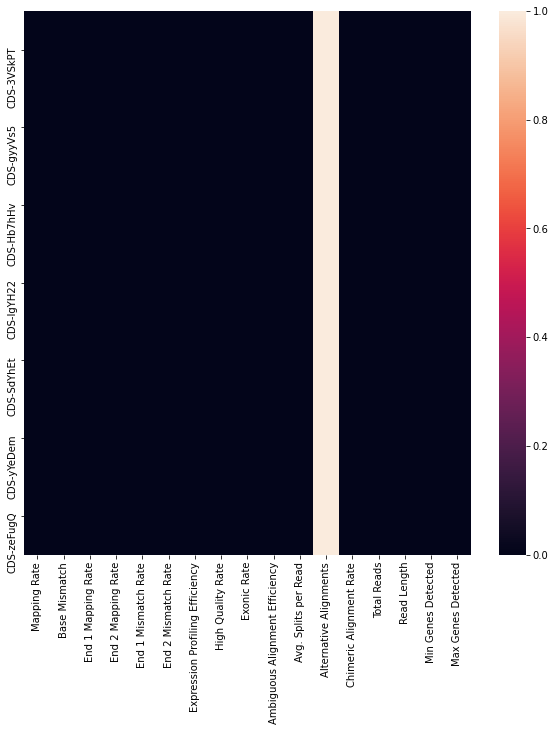

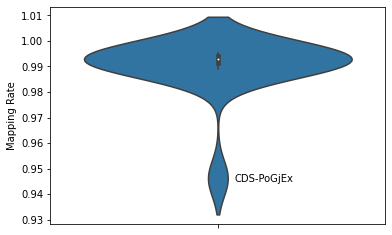

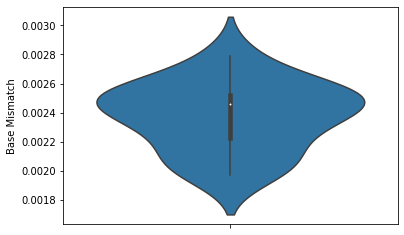

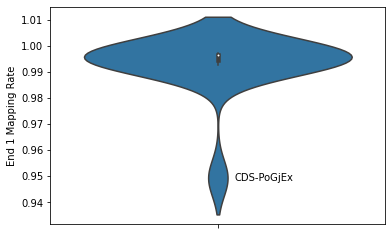

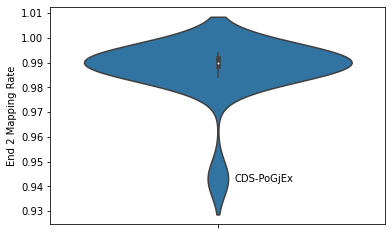

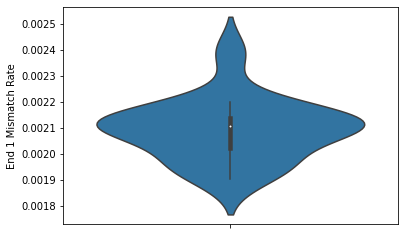

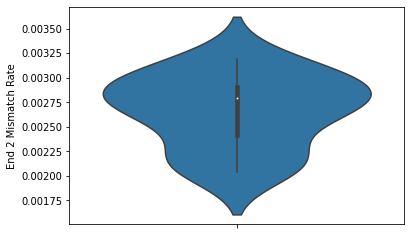

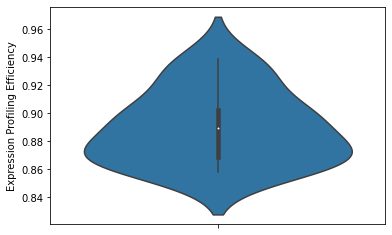

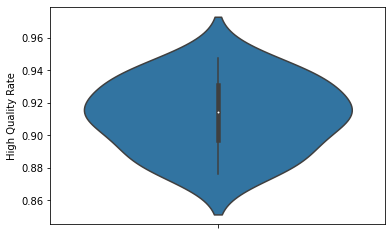

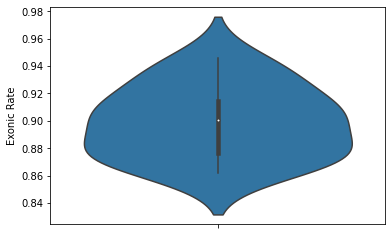

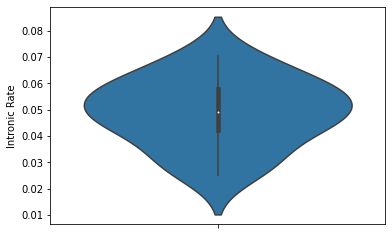

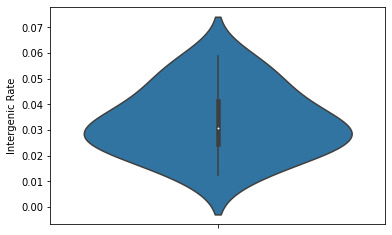

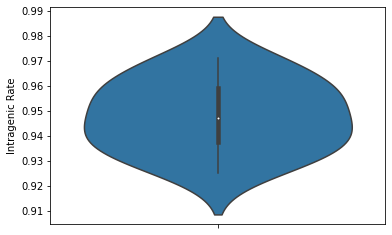

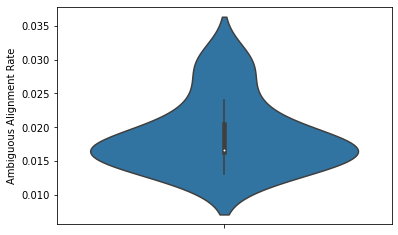

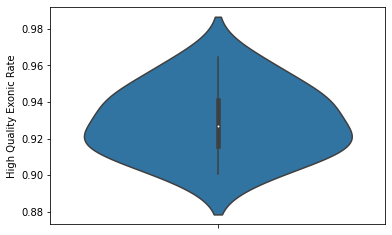

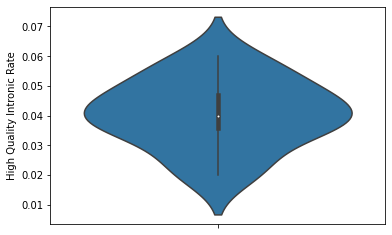

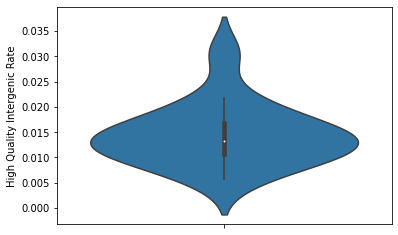

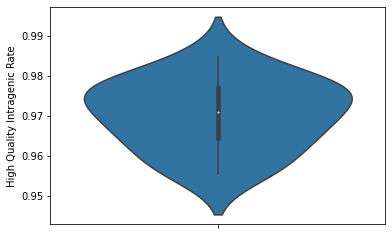

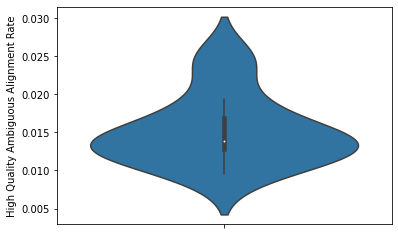

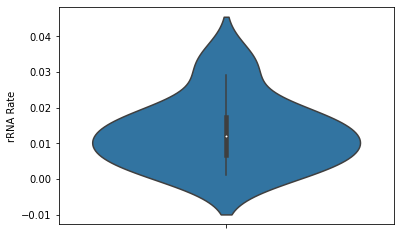

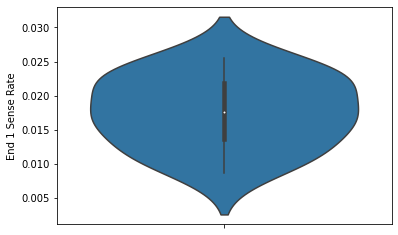

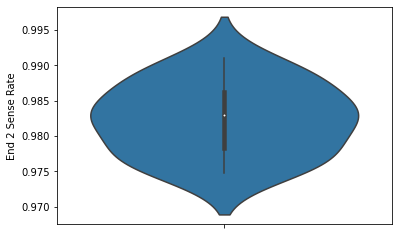

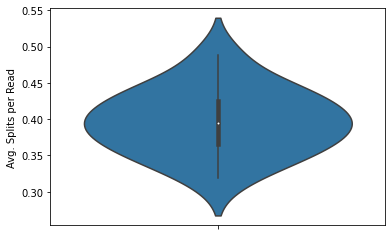

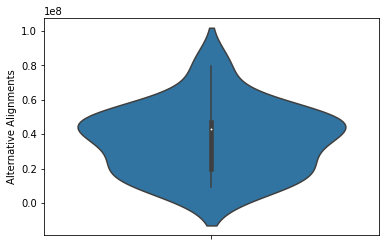

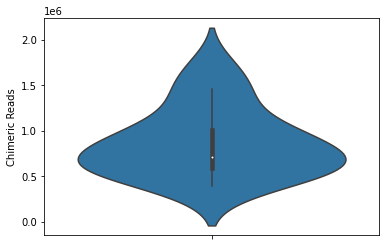

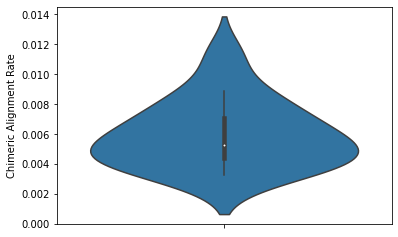

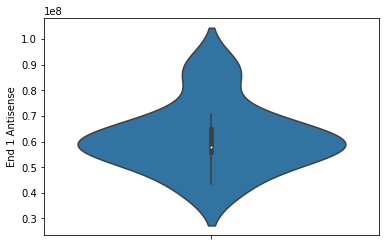

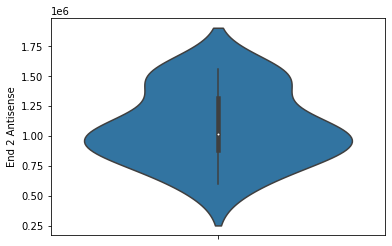

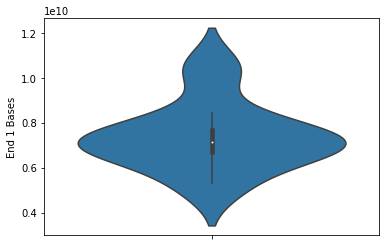

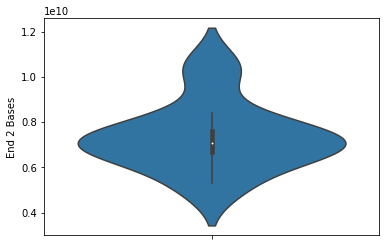

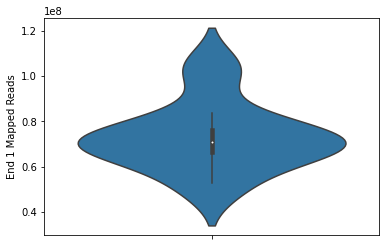

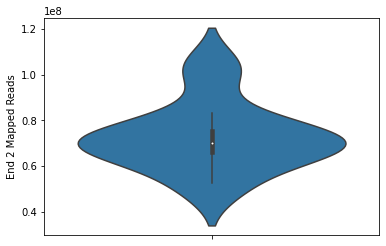

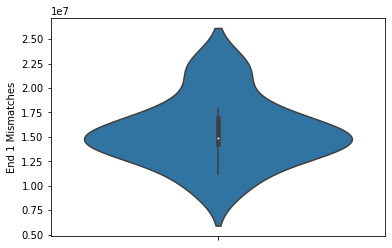

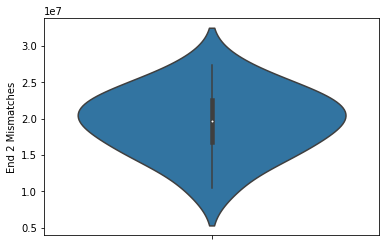

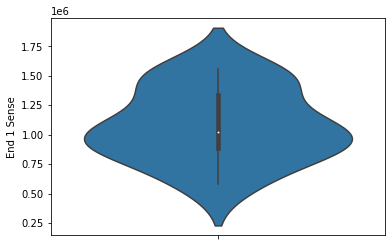

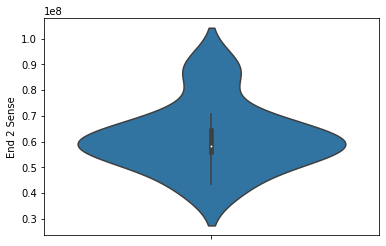

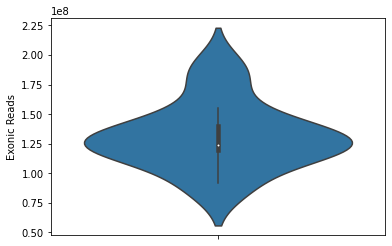

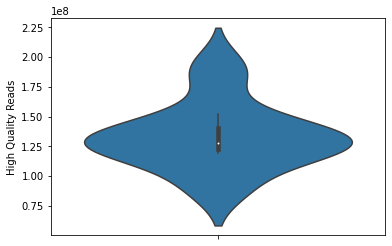

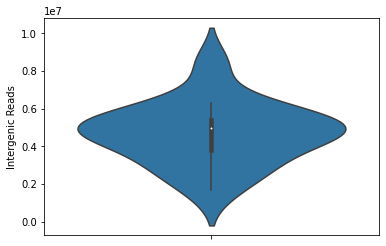

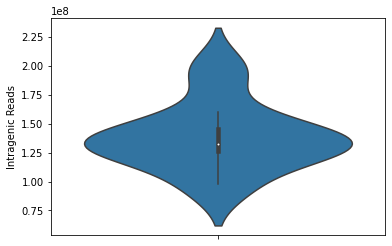

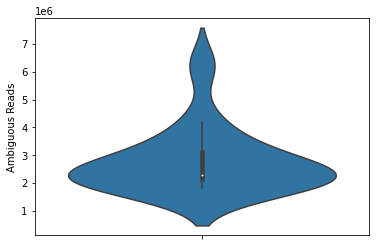

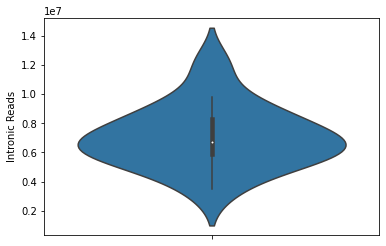

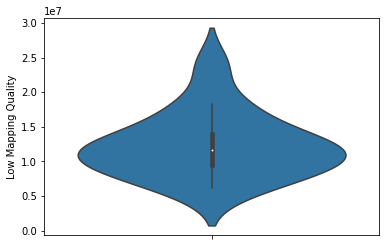

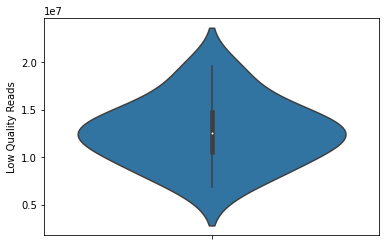

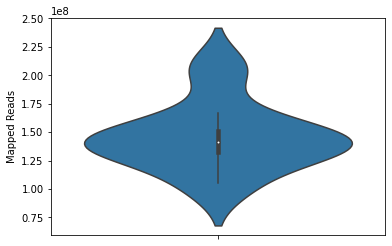

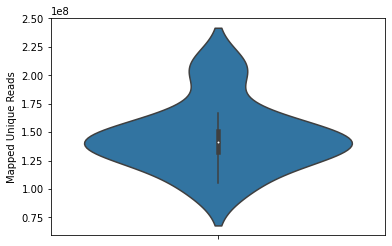

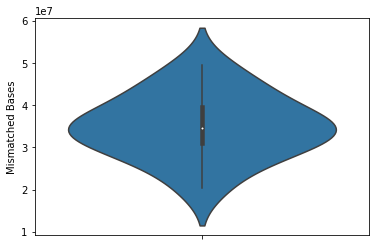

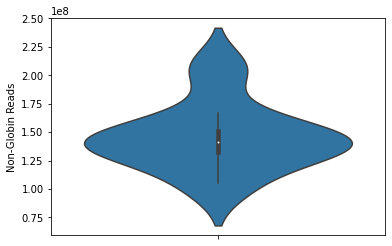

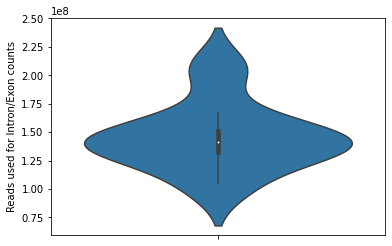

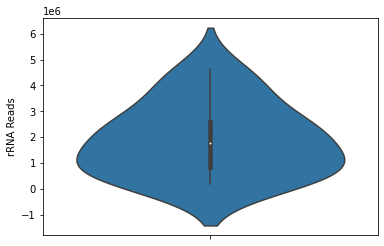

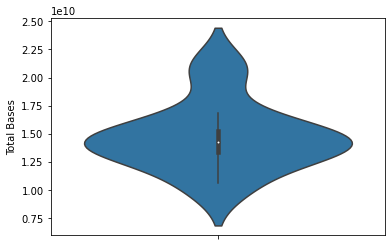

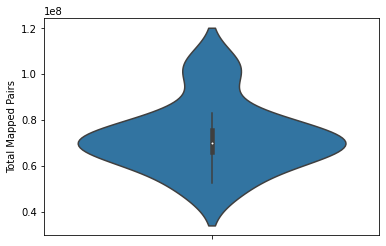

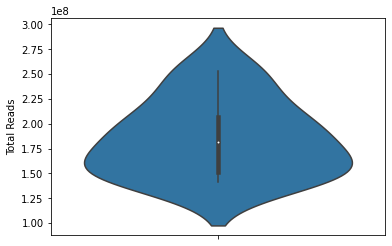

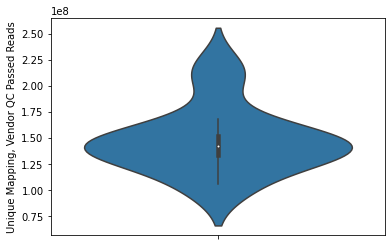

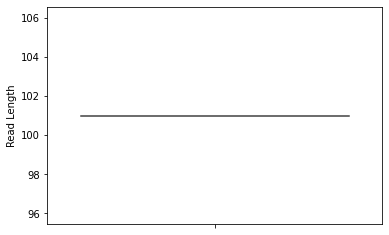

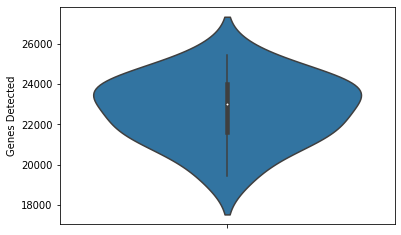

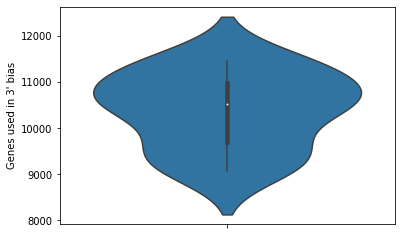

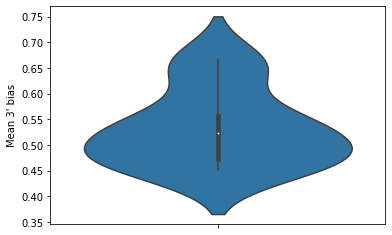

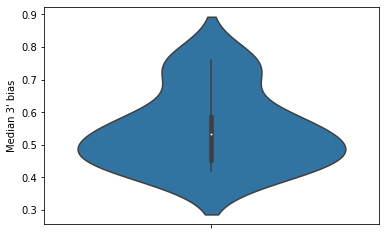

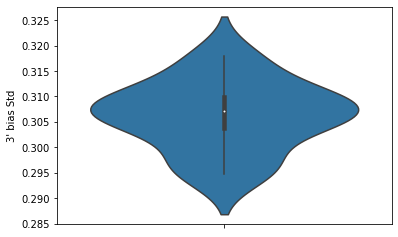

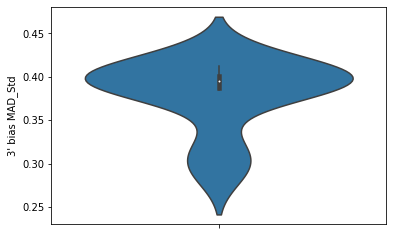

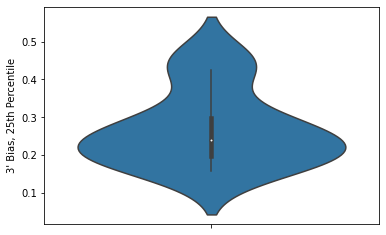

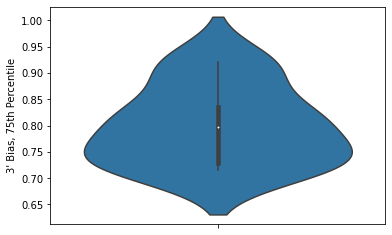

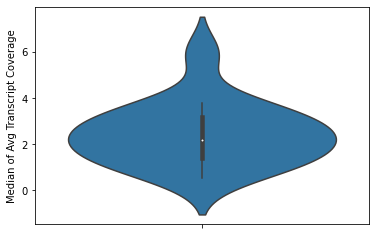

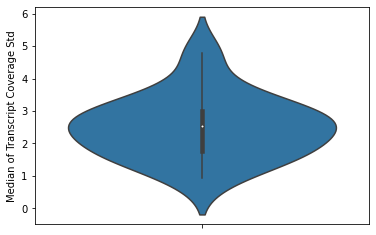

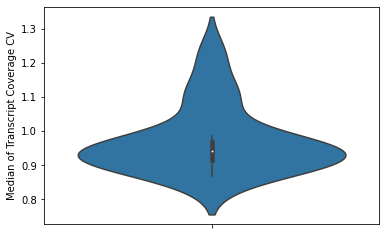

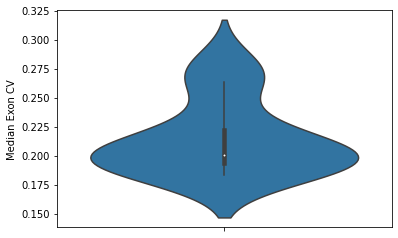

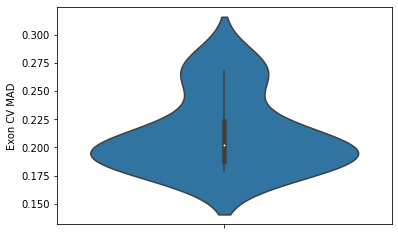

<Figure size 432x288 with 0 Axes>

In [406]:
lowqual = rna.filterRNAfromQC(qcs, thresholds={'minmapping': 0.85,
                                          'minendmapping': 0.75,
                                          'minefficiency': 0.75,
                                          'maxendmismatch': 0.02,
                                          'maxmismatch': 0.02,
                                          'minhighqual': 0.8,
                                          'minexon': 0.7,
                                          "maxambiguous": 0.05,
                                          "maxsplits": 0.1,
                                          "maxalt": 0.2,
                                          "maxchim": 0.05,
                                          "minreads": 20000000,
                                          "minlength": 80,
                                          "maxgenes": 35000,
                                          "mingenes": 12000,
                                          }, folder='data/rna_qc_plots/lowqual_'+samplesetname+"/", plot=True, qant1=0.1, qant3=0.9)

In [408]:
failed = rna.filterRNAfromQC(qcs, thresholds={'minmapping': 0.7,
                                          'minendmapping': 0.66,
                                          'minefficiency': 0.6,
                                          'maxendmismatch': 0.02,
                                          'maxmismatch': 0.02,
                                          'minhighqual': 0.7,
                                          'minexon': 0.66,
                                          "maxambiguous": 0.1,
                                          "maxsplits": 0.1,
                                          "maxalt": 0.5,
                                          "maxchim": 0.2,
                                          "minreads": 20000000,
                                          "minlength": 80,
                                          "maxgenes": 35000,
                                          "mingenes": 10000,
                                          }, folder='data/rna_qc_plots/'+samplesetname+"/", plot=True, qant1=0.07, qant3=0.93)

[]


In [411]:
failed = failed.index.tolist()

In [412]:
failed.extend(['CDS-12DTEw', 'CDS-9hv1zM', 'CDS-A6GSeQ', 'CDS-aWlMRt', 'CDS-B1ywOH', 'CDS-BixxtG', 'CDS-DRM3l2', 'CDS-jOlYT4', 'CDS-KMhiT9', 'CDS-M6mnMA', 'CDS-pYwECX', 'CDS-v6E624', 'CDS-vxTqNJ', 'CDS-YxtmkI'])
print('you want to copy that up top, to save it for next time',failed)

you want to copy that up top, to save it for next time [['CDS-12DTEw', 'CDS-9hv1zM', 'CDS-A6GSeQ', 'CDS-aWlMRt', 'CDS-B1ywOH', 'CDS-BixxtG', 'CDS-DRM3l2', 'CDS-jOlYT4', 'CDS-KMhiT9', 'CDS-M6mnMA', 'CDS-pYwECX', 'CDS-v6E624', 'CDS-vxTqNJ', 'CDS-YxtmkI']]


In [656]:
failed

['CDS-12DTEw',
 'CDS-9hv1zM',
 'CDS-A6GSeQ',
 'CDS-aWlMRt',
 'CDS-B1ywOH',
 'CDS-BixxtG',
 'CDS-DRM3l2',
 'CDS-jOlYT4',
 'CDS-KMhiT9',
 'CDS-M6mnMA',
 'CDS-pYwECX',
 'CDS-v6E624',
 'CDS-vxTqNJ',
 'CDS-YxtmkI']

In [417]:
ccle_refsamples = sheets.get(refsheet_url).sheets[0].to_frame(index_col=0)

In [418]:
for k,v in starlogs.items():
    if k =='nan':
        continue
    if ccle_refsamples.loc[k,'bam_qc']!=v[0]:
        ccle_refsamples.loc[k,'bam_qc']=v[0]

In [ ]:
dfToSheet(ccle_refsamples,'ccle sample tracker', secret=creds)

In [511]:
newfail = []
# finding other replicates to solve failed ones
for val in failed:
    a = ccle_refsamples.loc[val].arxspan_id
    res = ccle_refsamples[(ccle_refsamples.datatype == 'rna') &(ccle_refsamples.arxspan_id == a)]
    if len(res)>1:
        for k in res.index:
            if k not in failed:
                renaming[k] = renaming.pop(val)
    else:
        newfail.append(renaming.pop(val))
failed = newfail
newfail

ACH-000992
ACH-000727
ACH-001143
ACH-001502
ACH-000979
ACH-000309
ACH-001293
ACH-000047
ACH-001205
ACH-000426
ACH-001512
ACH-002709
ACH-001740
ACH-000795


### Remove some datafile to save money

In [419]:
res = refwm.get_samples()

In [128]:
colstoremove = ['fastq1', 'fastq2','recalibrated_bam','recalibrated_bam_index']
for val in colstoremove:
    refwm.disable_hound().delete_entity_attributes('sample', res[val], delete_files=True)

Successfully deleted attribute fastq1 for 1497 samples.
Successfully deleted attribute fastq2 for 1497 samples.


KeyError: 'recalibrated_bam'

In [420]:
samplesinset = samples.index.tolist()
#samplesinset= [i['entityName'] for i in refwm.get_entities('sample_set').loc[samplesetname].samples]

In [423]:
## copy star bam file to our cclebams/rnasq_hg38/ bucket
renamed, _ = terra.changeGSlocation(workspacefrom=refworkspace, newgs="gs://cclebams/rnasq_hg38/", onlysamples=samplesinset, onlycol=["star_bam_file",'star_bam_index'], entity="sample", keeppath=False,dry_run=False)

using the data from broad-firecloud-ccle/DepMap_hg38_RNAseq sample list
this should only contains gs:// paths otherwise precise columns using "onlycol"
Successfully updated attributes '['star_bam_file', 'star_bam_index']' for 15 samples.


In [ ]:
ccle_refsamples = sheets.get(refsheet_url).sheets[0].to_frame(index_col=0)

In [424]:
renamed

,star_bam_file,star_bam_index
CDS-2FgC1U,gs://cclebams/rnasq_hg38/CDS-2FgC1U.Aligned.so...,gs://cclebams/rnasq_hg38/CDS-2FgC1U.Aligned.so...
CDS-3VSkPT,gs://cclebams/rnasq_hg38/CDS-3VSkPT.Aligned.so...,gs://cclebams/rnasq_hg38/CDS-3VSkPT.Aligned.so...
CDS-a8BCnW,gs://cclebams/rnasq_hg38/CDS-a8BCnW.Aligned.so...,gs://cclebams/rnasq_hg38/CDS-a8BCnW.Aligned.so...
CDS-GOI63U,gs://cclebams/rnasq_hg38/CDS-GOI63U.Aligned.so...,gs://cclebams/rnasq_hg38/CDS-GOI63U.Aligned.so...
CDS-gyyVs5,gs://cclebams/rnasq_hg38/CDS-gyyVs5.Aligned.so...,gs://cclebams/rnasq_hg38/CDS-gyyVs5.Aligned.so...
CDS-Hb7hHv,gs://cclebams/rnasq_hg38/CDS-Hb7hHv.Aligned.so...,gs://cclebams/rnasq_hg38/CDS-Hb7hHv.Aligned.so...
CDS-IgYH22,gs://cclebams/rnasq_hg38/CDS-IgYH22.Aligned.so...,gs://cclebams/rnasq_hg38/CDS-IgYH22.Aligned.so...
CDS-J80Eb1,gs://cclebams/rnasq_hg38/CDS-J80Eb1.Aligned.so...,gs://cclebams/rnasq_hg38/CDS-J80Eb1.Aligned.so...
CDS-ldvG6N,gs://cclebams/rnasq_hg38/CDS-ldvG6N.Aligned.so...,gs://cclebams/rnasq_hg38/CDS-ldvG6N.Aligned.so...
CDS-LFK9QA,gs://cclebams/rnasq_hg38/CDS-LFK9QA.Aligned.so...,gs://cclebams/rnasq_hg38/CDS-LFK9QA.Aligned.so...


In [425]:
ccle_refsamples.loc[samplesinset,['legacy_bam_filepath','legacy_bai_filepath','legacy_size','legacy_crc32c_hash']] = ccle_refsamples.loc[samplesinset][['internal_bam_filepath','internal_bai_filepath','size','crc32c_hash']]

ccle_refsamples.loc[samplesinset,'internal_bam_filepath'] = renamed['star_bam_file']

ccle_refsamples.loc[samplesinset,'internal_bai_filepath'] = renamed['star_bam_index']

ccle_refsamples.loc[samplesinset,'size'] = [gcp.extractSize(i)[1] for i in gcp.lsFiles(renamed['star_bam_file'].tolist(),'-l')]
ccle_refsamples.loc[samplesinset,'crc32c_hash'] = [gcp.extractHash(i) for i in gcp.lsFiles(renamed['star_bam_file'].tolist(),'-L')]

listing files in gs
listing files in gs


In [428]:
dfToSheet(ccle_refsamples,'ccle sample tracker', secret=creds)

### Expression post processing

#### loading the files

In [687]:
res = refwm.get_sample_sets().loc['all']
rsem_genes_expected_count = res['rsem_genes_expected_count']
rsem_genes_tpm = res['rsem_genes_tpm']
rsem_transcripts_tpm = res['rsem_transcripts_tpm']
rsem_transcripts_expected_count = res['rsem_transcripts_expected_count']
! gsutil cp $rsem_genes_expected_count "temp/rsem_genes_expected_count" & gsutil cp $rsem_genes_tpm "temp/rsem_genes_tpm" & gsutil cp $rsem_transcripts_tpm "temp/rsem_transcripts_tpm" & gsutil cp $rsem_transcripts_expected_count "temp/rsem_transcripts_expected_count"

Copying gs://fc-secure-639c94ba-2b0d-4960-92fc-9cd50046a968/efcf68f6-73a8-4d28-9200-99e2f8e9a84d/rsem_aggregate_results_workflow/a75ed264-7e9d-4c4d-b74b-7a74adc71e69/call-rsem_aggregate_results/all.rsem_transcripts_tpm.txt.gz...
Copying gs://fc-secure-639c94ba-2b0d-4960-92fc-9cd50046a968/efcf68f6-73a8-4d28-9200-99e2f8e9a84d/rsem_aggregate_results_workflow/a75ed264-7e9d-4c4d-b74b-7a74adc71e69/call-rsem_aggregate_results/all.rsem_transcripts_expected_count.txt.gz...
Copying gs://fc-secure-639c94ba-2b0d-4960-92fc-9cd50046a968/efcf68f6-73a8-4d28-9200-99e2f8e9a84d/rsem_aggregate_results_workflow/a75ed264-7e9d-4c4d-b74b-7a74adc71e69/call-rsem_aggregate_results/all.rsem_genes_expected_count.txt.gz...
Copying gs://fc-secure-639c94ba-2b0d-4960-92fc-9cd50046a968/efcf68f6-73a8-4d28-9200-99e2f8e9a84d/rsem_aggregate_results_workflow/a75ed264-7e9d-4c4d-b74b-7a74adc71e69/call-rsem_aggregate_results/all.rsem_genes_tpm.txt.gz...
\ [1 files][ 75.7 MiB/ 75.7 MiB]                                          

In [688]:
files = {}
renaming = {}
for val in ["temp/rsem_transcripts_tpm","temp/rsem_genes_tpm", "temp/rsem_genes_expected_count","temp/rsem_transcripts_expected_count"]:
    file = pd.read_csv(val, compression='gzip', header=0, sep='\t', quotechar='"', error_bad_lines=False)
    print(file.columns[:10])
    if len(renaming) == 0:
        # removing failed version
        renaming  = removeOlderVersions(names=file.columns[2:], refsamples=refwm.get_samples(), arxspan_id="arxspan_id", version="version")
        renaming.update({'transcript_id(s)':'transcript'})
        # if we have a replaceable failed version in our dataset
        for k, v in renaming.items():
            if k in rename:
                renaming[rename[k]] = renaming.pop(k)
    if val=="temp/rsem_genes_expected_count":
        replevel = file.drop(columns = 'transcript_id(s)').set_index('gene_id', drop=True)
        replevel = replevel[(replevel.sum(1) != 0) & (replevel.var(1) != 0)]
    # we remove the failed samples where we did not found anything else to replace them with
    files[val.split('/')[-1]] = file[file.columns[:2].tolist()+[i for i in file.columns[2:] if i in set(renaming.keys())]].rename(columns=renaming)

Index(['transcript_id', 'gene_id', 'CDS-010xbm', 'CDS-02TzJp', 'CDS-0693hw',
       'CDS-07Plat', 'CDS-0BNTL7', 'CDS-0CqPRM', 'CDS-0EOjym', 'CDS-0Jkjew'],
      dtype='object')
removed 67 duplicate samples
Index(['gene_id', 'transcript_id(s)', 'CDS-010xbm', 'CDS-02TzJp', 'CDS-0693hw',
       'CDS-07Plat', 'CDS-0BNTL7', 'CDS-0CqPRM', 'CDS-0EOjym', 'CDS-0Jkjew'],
      dtype='object')
Index(['gene_id', 'transcript_id(s)', 'CDS-010xbm', 'CDS-02TzJp', 'CDS-0693hw',
       'CDS-07Plat', 'CDS-0BNTL7', 'CDS-0CqPRM', 'CDS-0EOjym', 'CDS-0Jkjew'],
      dtype='object')
Index(['transcript_id', 'gene_id', 'CDS-010xbm', 'CDS-02TzJp', 'CDS-0693hw',
       'CDS-07Plat', 'CDS-0BNTL7', 'CDS-0CqPRM', 'CDS-0EOjym', 'CDS-0Jkjew'],
      dtype='object')


#### generating gene names

In [517]:
server = BiomartServer( "http://www.ensembl.org/biomart" )
ensmbl = server.datasets['hsapiens_gene_ensembl']
ensembltohgnc = pd.read_csv(io.StringIO(ensmbl.search({
  'attributes': ['ensembl_gene_id','clone_based_ensembl_gene','hgnc_symbol','gene_biotype','entrezgene_id']
}, header=1).content.decode()), sep='\t')

ensembltohgnc.columns = ['ensembl_gene_id','clone_based_ensembl_gene','hgnc_symbol','gene_biotype','entrezgene_id']
ensembltohgnc = ensembltohgnc[~(ensembltohgnc['clone_based_ensembl_gene'].isna() & ensembltohgnc['hgnc_symbol'].isna())]
ensembltohgnc.loc[ensembltohgnc[ensembltohgnc.hgnc_symbol.isna()].index,"hgnc_symbol"] = ensembltohgnc[ensembltohgnc.hgnc_symbol.isna()]['clone_based_ensembl_gene']

gene_rename =  {i.ensembl_gene_id: i.hgnc_symbol+' ('+i.ensembl_gene_id+')' for k,i in ensembltohgnc.iterrows()}

KeyboardInterrupt: 

In [691]:
protcod_rename = {i.ensembl_gene_id: i.hgnc_symbol+' ('+str(int(i.entrezgene_id))+')' for _,i in ensembltohgnc[(~ensembltohgnc.entrezgene_id.isna()) & (ensembltohgnc.gene_biotype=='protein_coding')].iterrows()}

#### renaming the files

In [692]:
# gene level
for val in ['rsem_genes_expected_count','rsem_genes_tpm']:
    file = files[val].drop(columns='transcript').set_index('gene_id')
    file = file[(file.sum(1) != 0) & (file.var(1) != 0)]
    r = [i.split('.')[0] for i in file.index]
    dup = h.dups(r)
    if len(dup)>0:
        print(dup)
        raise ValueError('duplicate genes')
    file.index = r
    files[val.replace('genes','proteincoding_genes')] = file[file.index.isin(set(ensembltohgnc[ensembltohgnc.gene_biotype == 'protein_coding'].ensembl_gene_id))]
    files[val] = file.rename(index=gene_rename).T
    files[val.replace('genes','proteincoding_genes')] = files[val.replace('genes','proteincoding_genes')].rename(index=protcod_rename).T

In [693]:
# transcript level
rename_transcript = {}
missing = []
for val in ['rsem_transcripts_expected_count','rsem_transcripts_tpm']:
    file = files[val]
    file = file[(file[file.columns[2:]].sum(1) != 0) & (file[file.columns[2:]].var(1) != 0)]
    r = [i.split('.')[0] for i in file.transcript_id]
    dup = h.dups(r)
    if len(dup)>0:
        print(dup)
        raise ValueError('duplicate genes')    
    file.transcript_id = r
    if len(rename_transcript)==0:
        for _,v in file.iterrows():
            if v.gene_id.split('.')[0] in gene_rename:
                rename_transcript[v.transcript_id] = gene_rename[v.gene_id.split('.')[0]].split(' (')[0] + ' (' + v.transcript_id + ')'
            else:
                missing.append(v.gene_id.split('.')[0])
        print('missing: '+str(len(missing))+' genes')
    files[val] = file.set_index('transcript_id').drop(columns = 'gene_id').rename(index = rename_transcript).T

/home/jeremie/miniconda3/lib/python3.7/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


missing: 1068 genes


/home/jeremie/miniconda3/lib/python3.7/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [694]:
# removing genes that did not match.. pretty unfortunate 
files['rsem_proteincoding_genes_expected_count'] = files['rsem_proteincoding_genes_expected_count'][[i for i in files['rsem_proteincoding_genes_expected_count'].columns if ' (' in i]]
files['rsem_proteincoding_genes_tpm'] = files['rsem_proteincoding_genes_tpm'][[i for i in files['rsem_proteincoding_genes_tpm'].columns if ' (' in i]]

In [695]:
# check: do we have any duplicates?
h.dups(files['rsem_proteincoding_genes_expected_count'].columns.tolist())

[]

In [478]:
# if we do, managing duplicates
for val in ['rsem_proteincoding_genes_expected_count', 'rsem_proteincoding_genes_tpm']:
    for dup in h.dups(files[val].columns):
        a = files[val][dup].sum()
        files[val].drop(columns=dup)
        files[val][dup] = a

#### saving samples used for the release

In [696]:
ccle_refsamples = sheets.get(refsheet_url).sheets[0].to_frame(index_col=0)

Traceback (most recent call last):
  File "/home/jeremie/miniconda3/lib/python3.7/site-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jeremie/miniconda3/lib/python3.7/site-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jeremie/miniconda3/lib/python3.7/site-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.locked_file'

During handlin

In [455]:
ccle_refsamples.loc[set(renaming.keys())-set(['transcript_id(s)']),release]=1
ccle_refsamples.loc[ccle_refsamples[ccle_refsamples.datatype=='rna'].index,'low_quality']=0
ccle_refsamples.loc[lowqual[lowqual.sum(1)>3].index.tolist(),'low_quality']=1
ccle_refsamples.to_csv('temp/updated_ref_samples.csv')

In [456]:
dfToSheet(ccle_refsamples,'ccle sample tracker', secret=creds)

### validation

In [469]:
files.keys()

dict_keys(['rsem_transcripts_tpm', 'rsem_genes_tpm', 'rsem_genes_expected_count', 'rsem_transcripts_expected_count', 'rsem_proteincoding_genes_expected_count', 'rsem_proteincoding_genes_tpm'])

In [697]:
prevcounts = tc.get(name='depmap-a0ab', file='CCLE_RNAseq_reads')
overlap = set(prevcounts.columns) & set(files['rsem_genes_expected_count'].columns)
len(overlap)

[##################]100% |  22.8 MiB/s | 564.5 MiB / 564.5 MiB | Time:  0:00:24


52402

In [698]:
# have we lost any files compared to last release?
lost = set(prevcounts.index) - set(files['rsem_proteincoding_genes_tpm'].index)
%store failed
lost

Stored 'rnafailed' (set)


set()

In [376]:
# do we have samples that are missanotated compared to previous releases (replicate level)
notindataset, missannotated, unmatched = findMissAnnotatedReplicates(replevel, prevcounts, renaming)

In [379]:
for k,v in unmatched.items():
    if ccle_refsamples.loc[k].arxspan_id!=v:
        print(k,v)

In [ ]:
ccle_refsamples = sheets.get(refsheet_url).sheets[0].to_frame(index_col=0)
normals = ccle_refsamples[ccle_refsamples['primary_disease']=='normal'].index.tolist()
normals

In [ ]:
#for k,val in files.items():
    #files[k] = val.drop(index=normals)

In [699]:
# do we have samples that are missanotated compared to previous releases (sample level)
unmatched = rna.getDifferencesFromCorrelations(files['rsem_genes_expected_count'] ,prevcounts, minsimi=0.95)
unmatched

52402 overlap
ACH-001707 not in second df
ACH-002687 not in second df
ACH-001046 not in second df
ACH-001577 not in second df
ACH-001227 not in second df
ACH-001434 not in second df
ACH-002077 not in second df
ACH-002080 not in second df
ACH-001633 not in second df
ACH-002034 not in second df
ACH-002013 not in second df
ACH-001686 not in second df
ACH-002463 not in second df
ACH-001338 not in second df
ACH-001641 not in second df
ACH-002084 not in second df
ACH-001759 not in second df
ACH-002476 not in second df
ACH-001996 not in second df
ACH-001756 not in second df
ACH-001992 not in second df
ACH-001760 not in second df
ACH-002047 not in second df
ACH-001388 not in second df
ACH-001553 not in second df
ACH-001758 not in second df
ACH-001151 not in second df
ACH-002707 not in second df
found 1 samples that did not match


[('ACH-001429', 0.8896489745975775)]

In [467]:
# Is it because of  duplicate version?
rnasamples = ccle_refsamples[ccle_refsamples.datatype=='rna']
for i,val in unmatched:
    print(len(rnasamples[rnasamples.arxspan_id==i]))

1


### ssGSEA

In [701]:
counts_genes = files['rsem_genes_expected_count'].copy()

In [702]:
counts_genes

,TSPAN6 (ENSG00000000003),TNMD (ENSG00000000005),DPM1 (ENSG00000000419),SCYL3 (ENSG00000000457),C1orf112 (ENSG00000000460),FGR (ENSG00000000938),CFH (ENSG00000000971),FUCA2 (ENSG00000001036),GCLC (ENSG00000001084),NFYA (ENSG00000001167),...,ERCC-00157,ERCC-00158,ERCC-00160,ERCC-00162,ERCC-00163,ERCC-00164,ERCC-00165,ERCC-00168,ERCC-00170,ERCC-00171
ACH-001113,2383.0,0.0,4766.0,961.74,1518.30,2.0,162.85,565.47,9077.9,4280.0,...,0.0,0.0,2.0,44.0,8.0,0.0,13.0,1.0,8.0,1059.0
ACH-001289,2529.0,13.0,3857.0,555.00,833.00,0.0,19.14,999.85,1758.0,1684.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACH-001339,1552.0,0.0,8057.0,849.46,2511.50,2.0,201.84,13834.00,2189.0,2892.0,...,10.0,1.0,12.0,178.0,34.0,0.0,64.0,2.0,32.0,5747.0
ACH-001538,5657.0,0.0,6056.0,1056.70,656.26,0.0,7713.00,7927.50,3473.0,3378.0,...,6.0,2.0,11.0,185.0,35.0,1.0,64.0,2.0,38.0,6173.0
ACH-000242,22806.0,0.0,4702.0,1109.30,1499.70,98.0,31296.00,5913.60,22393.0,4773.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-000750,1959.0,0.0,4186.0,553.73,942.27,1.0,23.72,3722.20,3280.0,3951.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACH-000285,9.0,0.0,4571.0,2216.40,4013.60,42.0,15.00,64.88,3986.0,7817.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACH-001858,4790.0,0.0,7734.0,826.97,1105.00,3.0,1919.90,18576.00,8916.0,3311.0,...,10.0,0.0,16.0,126.0,35.0,0.0,95.0,2.0,43.0,6615.0
ACH-001997,41694.0,0.0,66739.0,7319.40,11022.00,5.0,16110.00,91361.00,22693.0,13383.0,...,43.0,0.0,96.0,464.0,181.0,1.0,315.0,0.0,83.0,27312.0


In [703]:
[i for i in counts_genes.columns if 'MYC' in i]

['MYCBP2 (ENSG00000005810)',
 'MYCL (ENSG00000116990)',
 'MYCT1 (ENSG00000120279)',
 'MYCN (ENSG00000134323)',
 'MYCBPAP (ENSG00000136449)',
 'MYC (ENSG00000136997)',
 'MYCLP1 (ENSG00000204053)',
 'MYCBP (ENSG00000214114)',
 'MYCNUT (ENSG00000223850)',
 'MYCLP2 (ENSG00000228004)',
 'MYCBP2-AS2 (ENSG00000229521)',
 'MYCNOS (ENSG00000233718)',
 'MYCBP2-AS1 (ENSG00000236051)',
 'MYCL-AS1 (ENSG00000236546)']

In [704]:
counts_genes.columns = [i.split(' (')[0] for i in counts_genes.columns]

In [705]:
for i in h.dups(counts_genes.columns):
    val = counts_genes[i].sum(1)
    counts_genes=counts_genes.drop(columns=i)
    counts_genes[i]=val

/home/jeremie/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [706]:
len(set([val for val in counts_genes.columns if '.' not in val]))

35246

In [758]:
# MAYBE NOT NEEDED
#### merging splicing variants into the same gene
#counts_genes_merged, _, _= h.mergeSplicingVariants(counts_genes.T, defined='.')
counts_genes

renamed: 3755 genes and dropped 7473


#### with R ssGSEA on the console

In [707]:
enrichments= rna.gsva(counts_genes.T, pathtoJKBio="../JKBio/", geneset_file = "data/genesets/msigdb.v7.2.symbols.gmt", method='ssgsea').T
enrichments.index = [i.replace('.','-') for i in enrichments.index]

CompletedProcess(args='Rscript ../JKBio//rna/ssGSEA.R /tmp/data_JKBIOhelper_gsva.csv data/genesets/msigdb.v7.2.symbols.gmt ssgsea', returncode=0, stdout=b'Estimating ssGSEA scores for 31118 gene sets.\n\r  |                                                                            \r  |                                                                      |   0%Using parallel with 12 cores\n\r  |                                                                            \r  |                                                                      |   1%\r  |                                                                            \r  |=                                                                     |   1%\r  |                                                                            \r  |=                                                                     |   2%\r  |                                                                            \r  |==                                

### Some predictions

In [ ]:
metadata = tc.get(name='depmap-a0ab', file='sample_info')
metadata

In [ ]:
# finding train and test set
trainame = [val for val in new1&prev if val[:3] == 'ACH']
testname = [val for val in new1-prev if val[:3] == 'ACH']

#looking at the 2000 most variable genes in the two sets
genetolookfor = 2000
gene_var = counts_genes[trainame].var(1).values
print(len(gene_var))
sorting = np.argsort(gene_var)[-genetolookfor:]

In [ ]:
unregistered = set(testname) - set(metadata["DepMap_ID"].values.tolist())
unregistered

In [ ]:
len(counts_genes['ACH-001767']) - np.count_nonzero(counts_genes['ACH-001767'].values)

In [ ]:
# creating and reodering train and test sets
traindata = counts_genes[set(trainame)-unregistered].values[sorting].T
trainlabels = [metadata[metadata["DepMap_ID"]==val]["disease"].values[0] for val in counts_genes[set(trainame)-unregistered].columns.tolist() if val not in unregistered]

testdata = counts_genes[set(testname)-unregistered].values[sorting].T
testlabels = [metadata[metadata["DepMap_ID"]==val]["disease"].values[0] for val in counts_genes[set(testname)-unregistered].columns.tolist() if val not in unregistered]
traindata.shape

In [ ]:
# learn KNN classifier to the metadata diseases
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(traindata, trainlabels) 
predicted = neigh.predict(testdata)
predicted[1]

In [ ]:
labels = trainlabels + testlabels
colors=[0]*len(trainlabels)
colors.extend([1,2,2,2,2,1,2,2,2,1,2])
data = np.vstack([traindata,testdata])

In [ ]:
# plot them with TSNE, highlight the points that failed and show colors for diseases
dimred = TSNE(2,10).fit_transform(data)

In [ ]:
scatter(dimred, labels=labels,colors=colors, radi=1.9)

### Save files for taiga

In [859]:
!ls temp/gene_sets_*

temp/gene_sets_20Q4_all.csv  temp/gene_sets_20Q4_All.csv


In [ ]:
#h.compareDfs(enrichments, tc.get(name='depmap-a0ab', file='CCLE_fusions_unfiltered'))

In [655]:
len(set(ccle_refsamples[ccle_refsamples.datatype=='rna'].arxspan_id))

1447

In [708]:
enrichments.to_csv('temp/gene_sets_'+release+'_all.csv')

In [538]:
#CCLE_expression, CCLE_expression_full, , 
#h.compareDfs(files["rsem_transcripts_tpm"], tc.get(name='depmap-a0ab', file='CCLE_RNAseq_transcripts'))
#h.compareDfs(files["rsem_transcripts_expected_count"], tc.get(name='depmap-a0ab', file='CCLE_expression_transcripts_expected_count'))
h.compareDfs(files["rsem_genes_expected_count"], tc.get(name='depmap-a0ab', file='CCLE_RNAseq_reads'))
h.compareDfs(files["rsem_genes_tpm"], tc.get(name='depmap-a0ab', file='CCLE_expression_full'))
h.compareDfs(files["rsem_proteincoding_genes_tpm"], tc.get(name='depmap-a0ab', file='CCLE_expression'))
h.compareDfs(files["rsem_proteincoding_genes_expected_count"], tc.get(name='depmap-a0ab', file = 'CCLE_expression_proteincoding_genes_expected_count'))

FOUND missmatch Columns IN df1: {'ENSG00000276735', 'PRXL2CP1 (ENSG00000237963)', 'AC073621.1 (ENSG00000227158)', 'AC138866.1 (ENSG00000254701)', 'AL645939.5 (ENSG00000285761)', 'PSME2P5 (ENSG00000253208)', 'CHP1P2 (ENSG00000213073)', 'FOLR1P1 (ENSG00000256518)', 'SRSF6P2 (ENSG00000235554)', 'AC006116.7 (ENSG00000267549)', 'AURKBP1 (ENSG00000230948)', 'CR382287.1 (ENSG00000279851)', 'AC146944.1 (ENSG00000253333)', 'AC090971.2 (ENSG00000259201)', 'AC099654.5 (ENSG00000283431)', 'RBMXP5 (ENSG00000217835)', 'AC134684.11 (ENSG00000285659)', 'AL353662.1 (ENSG00000233668)', 'TUBBP3 (ENSG00000258406)', 'AL451074.4 (ENSG00000230659)', 'BX119904.1 (ENSG00000230159)', 'AL049869.1 (ENSG00000259076)', 'AL357556.3 (ENSG00000285053)', 'CNEP1R1P1 (ENSG00000180284)', 'AC099782.1 (ENSG00000285788)', 'PKD1P3 (ENSG00000183458)', 'AC129492.6 (ENSG00000279152)', 'ENSG00000267702', 'SPTBN1-AS1 (ENSG00000228108)', 'NBPF13P (ENSG00000283342)', 'AC099689.3 (ENSG00000279416)', 'AC005674.1 (ENSG00000261490)', 'R


FOUND missmatch Columns NOT IN df1: {'AC135983.2 (ENSG00000215304)', 'AC145423.1 (ENSG00000270445)', 'AC100756.3 (ENSG00000273756)', 'AC011452.3 (ENSG00000276729)', 'AC145423.3 (ENSG00000278112)', 'AC104849.1 (ENSG00000237456)', 'AC022868.1 (ENSG00000253833)', 'LINC02203 (ENSG00000284988)', 'AC009309.2 (ENSG00000273080)', 'AC112492.5 (ENSG00000233243)', 'AC073342.3 (ENSG00000279223)', 'AC240565.1 (ENSG00000280136)', 'TSTA3 (ENSG00000104522)', 'AC022616.2 (ENSG00000234713)', 'AC111170.2 (ENSG00000267016)', 'AL157698.1 (ENSG00000231356)', 'AC111170.4 (ENSG00000279801)', 'Z82246.1 (ENSG00000236054)', 'AC010136.1 (ENSG00000223923)', 'AL121956.4 (ENSG00000280850)', 'AC099654.11 (ENSG00000284291)', 'AC099654.10 (ENSG00000284221)', 'AC091390.3 (ENSG00000239486)', 'AL445383.1 (ENSG00000258406)', 'AC004988.1 (ENSG00000203446)', 'AC026271.4 (ENSG00000276532)', 'AC112247.1 (ENSG00000177803)', 'AC068446.3 (ENSG00000258883)', 'AL953862.2 (ENSG00000271686)', 'AC138969.3 (ENSG00000257366)', 'AL39126

FOUND missmatch Index IN df1: {'ACH-001759', 'ACH-001046', 'ACH-001758', 'ACH-001760', 'ACH-001434', 'ACH-002476', 'ACH-001227', 'ACH-001756', 'ACH-001686', 'ACH-002047', 'ACH-002055'}
FOUND missmatch Index NOT IN df1: set()
FOUND new NAs in df1: -4138
FOUND new 0s in df1: 336386
FOUND missmatch Columns IN df1: {'ENSG00000276735', 'PRXL2CP1 (ENSG00000237963)', 'AC073621.1 (ENSG00000227158)', 'AC138866.1 (ENSG00000254701)', 'AL645939.5 (ENSG00000285761)', 'PSME2P5 (ENSG00000253208)', 'CHP1P2 (ENSG00000213073)', 'FOLR1P1 (ENSG00000256518)', 'SRSF6P2 (ENSG00000235554)', 'AC006116.7 (ENSG00000267549)', 'AURKBP1 (ENSG00000230948)', 'CR382287.1 (ENSG00000279851)', 'AC146944.1 (ENSG00000253333)', 'AC090971.2 (ENSG00000259201)', 'AC099654.5 (ENSG00000283431)', 'RBMXP5 (ENSG00000217835)', 'AC134684.11 (ENSG00000285659)', 'AL353662.1 (ENSG00000233668)', 'TUBBP3 (ENSG00000258406)', 'AL451074.4 (ENSG00000230659)', 'BX119904.1 (ENSG00000230159)', 'AL049869.1 (ENSG00000259076)', 'AL357556.3 (ENSG000

FOUND missmatch Columns NOT IN df1: {'AC135983.2 (ENSG00000215304)', 'AC145423.1 (ENSG00000270445)', 'AC100756.3 (ENSG00000273756)', 'AC011452.3 (ENSG00000276729)', 'AC145423.3 (ENSG00000278112)', 'AC104849.1 (ENSG00000237456)', 'AC022868.1 (ENSG00000253833)', 'LINC02203 (ENSG00000284988)', 'AC009309.2 (ENSG00000273080)', 'AC112492.5 (ENSG00000233243)', 'AC073342.3 (ENSG00000279223)', 'AC240565.1 (ENSG00000280136)', 'TSTA3 (ENSG00000104522)', 'AC022616.2 (ENSG00000234713)', 'AC111170.2 (ENSG00000267016)', 'AL157698.1 (ENSG00000231356)', 'AC111170.4 (ENSG00000279801)', 'Z82246.1 (ENSG00000236054)', 'AC010136.1 (ENSG00000223923)', 'AL121956.4 (ENSG00000280850)', 'AC099654.11 (ENSG00000284291)', 'AC099654.10 (ENSG00000284221)', 'AC091390.3 (ENSG00000239486)', 'AL445383.1 (ENSG00000258406)', 'AC004988.1 (ENSG00000203446)', 'AC026271.4 (ENSG00000276532)', 'AC112247.1 (ENSG00000177803)', 'AC068446.3 (ENSG00000258883)', 'AL953862.2 (ENSG00000271686)', 'AC138969.3 (ENSG00000257366)', 'AL391261


FOUND missmatch Index IN df1: {'ACH-001759', 'ACH-001046', 'ACH-001758', 'ACH-001760', 'ACH-001434', 'ACH-002476', 'ACH-001227', 'ACH-001756', 'ACH-001686', 'ACH-002047', 'ACH-002055'}
FOUND missmatch Index NOT IN df1: set()
FOUND new NAs in df1: -4021
FOUND new 0s in df1: 334248
FOUND missmatch Columns IN df1: {'CYP2D6 (1565)', 'DNAI3 (126820)', 'ERVH48-1 (90625)', 'STYXL2 (92235)', 'GFUS (7264)', 'LILRB3 (11025)', 'CENATAC (338657)', 'PIGY (100996939)', 'LY6G6D (58530)', 'GAGE2A (729447)', 'PEDS1 (387521)', 'PEDS1-UBE2V1 (387522)', 'AP000812.4 (220074)', 'TECTA (116804918)', 'SUPT20HL1 (100130302)', 'DYNC2I2 (89891)', 'IQANK1 (642574)', 'NPIPA1 (9284)', 'GOLGA6L1 (102723623)', 'CFAP94 (55259)', 'CCL4L2 (9560)', 'AC010255.2 (100505841)', 'AC069544.2 (100421372)', 'USP17L2 (377630)', 'CDIN1 (84529)', 'DEFB107A (245910)', 'AC002456.2 (102723899)', 'SPRING1 (79794)', 'TAS2R43 (259289)', 'TBC1D3K (101060351)', 'DUSP29 (338599)', 'POLR1F (221830)', 'CLDN12 (9069)', 'POLR1G (10849)', 'HOAT

({'AC002456.2 (102723899)',
  'AC010255.2 (100505841)',
  'AC069544.2 (100421372)',
  'AHRR (57491)',
  'AP000812.4 (220074)',
  'APOBEC3A (200315)',
  'ARL17B (100506084)',
  'BCAP29 (55973)',
  'C4A (720)',
  'CCL4L2 (9560)',
  'CDIN1 (84529)',
  'CENATAC (338657)',
  'CEP170 (9859)',
  'CFAP94 (55259)',
  'CHML (23596)',
  'CLDN12 (9069)',
  'CYP2D6 (1565)',
  'DAXX (1616)',
  'DEFB107A (245910)',
  'DEFB4A (1673)',
  'DNAI3 (126820)',
  'DNAI4 (79819)',
  'DUSP29 (338599)',
  'DYNC2I1 (55112)',
  'DYNC2I2 (89891)',
  'ERVH48-1 (90625)',
  'GAGE2A (729447)',
  'GFUS (7264)',
  'GOLGA6L1 (102723623)',
  'GOLGA8Q (727909)',
  'GOLGA8T (653075)',
  'GPX1 (2876)',
  'GTF2H2 (2966)',
  'HOATZ (399949)',
  'IQANK1 (642574)',
  'KATNIP (23247)',
  'KIR2DL1 (3802)',
  'LGALS7 (3963)',
  'LILRB3 (11025)',
  'LY6G6D (58530)',
  'MCL1 (574406)',
  'NPIPA1 (9284)',
  'P3R3URF-PIK3R3 (110117499)',
  'PEDS1 (387521)',
  'PEDS1-UBE2V1 (387522)',
  'PIGY (100996939)',
  'POLR1F (221830)',
  'POLR1G

In [700]:
for k,val in files.items():
    #h.compareDfs(val, tc.get(name='depmap-a0ab', file=k))
    val.to_csv('temp/'+k.replace('rsem','expression_'+release)+'.csv')

In [709]:
tc.update_dataset(dataset_permaname="expression-d035",
                 upload_file_path_dict={
    'temp/expression_'+release+'_transcripts_tpm.csv': 'NumericMatrixCSV',
    'temp/expression_'+release+'_genes_tpm.csv': 'NumericMatrixCSV',
    'temp/expression_'+release+'_genes_expected_count.csv': 'NumericMatrixCSV',
    'temp/expression_'+release+'_proteincoding_genes_expected_count.csv': 'NumericMatrixCSV',
    'temp/expression_'+release+'_proteincoding_genes_tpm.csv': 'NumericMatrixCSV',
    'temp/expression_'+release+'_transcripts_expected_count.csv': 'NumericMatrixCSV',
    'temp/gene_sets_'+release+'_all.csv': 'NumericMatrixCSV'
                },
                  dataset_description=
"""
# RNAseq

PORTAL TEAM SHOULD NOT USE THIS: There are lines here that should not make it even to internal.

/!\ This is the most up to date version of the CCLE RNA data.

## Annotations:

transcriptions (Transcripts rpkm):

genes (gene rpkm):
__Rows__:
__Columns__:
Counts (gene counts):
__Rows__:
__Columns__:
Gene level CN data:
__Rows__:
__Columns__:
 DepMap cell line IDs
 gene names in the format HGNC\_symbol (Entrez\_ID)
DepMap\_ID, Chromosome, Start, End, Num\_Probes, Segment\_Mean
""")

Uploading expression_21Q1_transcripts_tpm...
hitting https://cds.team/taiga/api/datafile/7da944068b084463afba0ea7f95fa388
Conversion and upload...:
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size 

	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploadin

hitting https://cds.team/taiga/api/datafile/7da944068b084463afba0ea7f95fa388
Conversion and upload...:
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 750
	 Conversion in progress, line 750
	 Conversion in progress, line 1000
	 Conversion in progress, line 1000
	 Conversion in progress, line 1000
	 Conversion in progress, line 1250
	 Conversion in progress, line 1250
	 Conversion in progress, line 1250
	 Conversion in progress, line 1250
	 Uploading to S3


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Fusion post processing

In [541]:
terra.saveConfigs(refworkspace,'data/'+samplesetname+'/RNAconfig')

/home/jeremie/miniconda3/lib/python3.7/site-packages/dalmatian/wmanager.py:1144: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df = pd.io.json.json_normalize(r)


In [ ]:
terra.waitForSubmission(refworkspace, submission_id2)

In [571]:
aggregated = refwm.get_sample_sets().loc['all']['fusions_star']

In [572]:
! gsutil cp $aggregated "temp/expression.fusion.tsv"

Copying gs://fc-secure-639c94ba-2b0d-4960-92fc-9cd50046a968/cfb1e697-12c9-41b1-8a38-e9b609151c5f/aggregate_set_files_workflow/dc61406a-667b-458c-afd4-db1efeed8406/call-aggregate_set_files/Fusions.aggregated.tsv...
- [1 files][ 97.3 MiB/ 97.3 MiB]                                                
Operation completed over 1 objects/97.3 MiB.                                     


In [752]:
fusions = pd.read_csv('temp/expression.fusion.tsv', names=['DepMap_ID', 'FusionName', 'JunctionReadCount', 'SpanningFragCount', 'SpliceType', 'LeftGene', 'LeftBreakpoint', 'RightGene', 'RightBreakpoint', 'LargeAnchorSupport', 'FFPM', 'LeftBreakDinuc', 'LeftBreakEntropy', 'RightBreakDinuc', 'RightBreakEntropy','annots'], skiprows=1, sep='\t')
fusions["DepMap_ID"] = [i.split('.')[0] for i in fusions['DepMap_ID']]

In [753]:
print(len(fusions))
renaming = removeOlderVersions(names=set(fusions['DepMap_ID']), refsamples=refwm.get_samples(), arxspan_id="arxspan_id", version="version")
print(len(fusions))
print(fusions['DepMap_ID'][:10])

378004
removed 67 duplicate samples
378004
0    CDS-010xbm
1    CDS-010xbm
2    CDS-010xbm
3    CDS-010xbm
4    CDS-010xbm
5    CDS-010xbm
6    CDS-010xbm
7    CDS-010xbm
8    CDS-010xbm
9    CDS-010xbm
Name: DepMap_ID, dtype: object


In [755]:
fusions['CCLE_count'] = [i.LeftBreakpoint+'_'+i.RightBreakpoint for k, i in fusions.iterrows()]
counts = Counter(list(fusions['CCLE_count']))
fusions['CCLE_count'] = [counts[val] for val in fusions['CCLE_count']]

<AxesSubplot:>

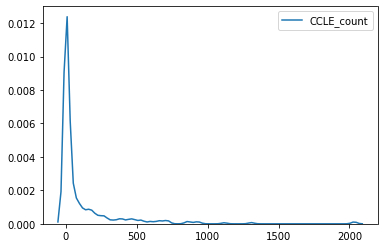

In [588]:
sns.kdeplot(fusions['CCLE_count'] )

In [577]:
fusions

,DepMap_ID,FusionName,JunctionReadCount,SpanningFragCount,SpliceType,LeftGene,LeftBreakpoint,RightGene,RightBreakpoint,LargeAnchorSupport,FFPM,LeftBreakDinuc,LeftBreakEntropy,RightBreakDinuc,RightBreakEntropy,annots,CCLE_count
0,ACH-001113,AC105177.1--LINC00536,44,282,INCL_NON_REF_SPLICE,AC105177.1^ENSG00000253672.1,chr8:116384887:-,LINC00536^ENSG00000249917.3,chr8:116261641:-,YES_LDAS,5.0684,GT,1.9656,AG,1.9086,"[""CCLE_StarF2019"",""INTRACHROMOSOMAL[chr8:0.08M...",1
1,ACH-001113,ADAM17--ITGB1BP1,44,94,ONLY_REF_SPLICE,ADAM17^ENSG00000151694.14,chr2:9543153:-,ITGB1BP1^ENSG00000119185.12,chr2:9414256:-,YES_LDAS,2.1455,GT,1.9086,AG,1.8892,"[""TCGA_StarF2019"",""INTRACHROMOSOMAL[chr2:0.06M...",1
2,ACH-001113,XRCC4--SUGCT,26,104,ONLY_REF_SPLICE,XRCC4^ENSG00000152422.15,chr5:83111203:+,SUGCT^ENSG00000175600.15,chr7:40749434:+,YES_LDAS,2.0211,GT,1.9656,AG,1.9656,"[""CCLE_StarF2019"",""INTERCHROMOSOMAL[chr5--chr7]""]",2
3,ACH-001113,CACNA2D1--SEMA3E,49,53,ONLY_REF_SPLICE,CACNA2D1^ENSG00000153956.16,chr7:82335135:-,SEMA3E^ENSG00000170381.14,chr7:83469302:-,YES_LDAS,1.5858,GT,1.9899,AG,1.9899,"[""CCLE_StarF2019"",""INTRACHROMOSOMAL[chr7:0.92M...",2
4,ACH-001113,ADNP2--PLIN3,50,40,INCL_NON_REF_SPLICE,ADNP2^ENSG00000101544.9,chr18:80117650:+,PLIN3^ENSG00000105355.9,chr19:4867657:-,YES_LDAS,1.3993,GT,1.7819,AG,1.8323,"[""CCLE_StarF2019"",""INTERCHROMOSOMAL[chr18--chr...",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361359,ACH-000052,UMAD1--GLCCI1,1,1,ONLY_REF_SPLICE,UMAD1^ENSG00000219545.11,chr7:7673453:+,GLCCI1^ENSG00000106415.12,chr7:8003908:+,NO_LDAS,0.0182,GT,1.8295,AG,1.7465,"[""GTEx_recurrent_StarF2019"",""INTRACHROMOSOMAL[...",112
361360,ACH-000052,VAPB--APCDD1L-DT,1,1,ONLY_REF_SPLICE,VAPB^ENSG00000124164.15,chr20:58418363:+,APCDD1L-DT^ENSG00000231290.5,chr20:58523169:+,YES_LDAS,0.0182,GT,1.8323,AG,1.9656,"[""INTRACHROMOSOMAL[chr20:0.06Mb]"",""NEIGHBORS[6...",33
361361,ACH-000052,VAPB--APCDD1L-DT,1,1,ONLY_REF_SPLICE,VAPB^ENSG00000124164.15,chr20:58418363:+,APCDD1L-DT^ENSG00000231290.5,chr20:58618740:+,YES_LDAS,0.0182,GT,1.8323,AG,1.9086,"[""INTRACHROMOSOMAL[chr20:0.06Mb]"",""NEIGHBORS[6...",25
361362,ACH-000052,VTI1A--AL158212.1,1,1,ONLY_REF_SPLICE,VTI1A^ENSG00000151532.13,chr10:112668998:+,AL158212.1^ENSG00000225292.2,chr10:112888735:+,NO_LDAS,0.0182,GT,1.7465,AG,1.8892,"[""GTEx_recurrent_StarF2019"",""INTRACHROMOSOMAL[...",188


In [759]:
fusions.RightGene = renameFusionGene(fusions.RightGene)
fusions.LeftGene = renameFusionGene(fusions.LeftGene)

In [760]:
fusions.to_csv('temp/fusions_withReplicates_'+release+'.csv',index=False)

In [732]:
fusions = pd.read_csv('temp/fusions_withReplicates_'+release+'.csv')

### Generate filtered fusion table

We want to apply filters to the fusion table to reduce the number of artifacts in the dataset. Specifically, we filter the following:

* Remove fusions involving mitochondrial chromosomes, or HLA genes, or immunoglobulin genes
* Remove red herring fusions (from STAR-Fusion annotations column)
* Remove recurrent in CCLE (>= 25 samples)
* Remove fusion with (SpliceType=" INCL_NON_REF_SPLICE" and LargeAnchorSupport="No" and FFPM < 0.1)
* Remove fusions with FFPM < 0.05 (STAR-Fusion suggests using 0.1, but looking at the translocation data, this looks like it might be too aggressive)


In [761]:
fusions = fusions[fusions['DepMap_ID'].isin(renaming.keys())].replace({'DepMap_ID':renaming}).reset_index(drop=True)

In [762]:
fusions['CCLE_count'] = [i.LeftBreakpoint+'_'+i.RightBreakpoint for k, i in fusions.iterrows()]
counts = Counter(list(fusions['CCLE_count']))
fusions['CCLE_count'] = [counts[val] for val in fusions['CCLE_count']]

In [763]:
filtered = filterFusions(fusions, maxfreq=0.1)

In [738]:
len(set(fusions.DepMap_ID))

1432

In [739]:
ccle_refsamples = sheets.get(refsheet_url).sheets[0].to_frame(index_col=0)
normals = ccle_refsamples[ccle_refsamples['primary_disease']=='normal'].index.tolist()
normals

['CDS-qoxhbS',
 'CDS-8qS051',
 'CDS-N4XOP4',
 'CDS-dHm43o',
 'CDS-RY8Xzr',
 'CDS-aW2WNp',
 'CDS-i3CvRQ',
 'CDS-ceYrXN',
 'CDS-Vn4Lqz',
 'CDS-ZTuykY',
 'CDS-uFRsR5',
 'CDS-2lPWAu',
 'CDS-BqISJN',
 'CDS-Lp8aNF',
 'CDS-y8dyN3',
 'CDS-9lQ9IO',
 'CDS-GV3cEP',
 'CDS-WzlUq5',
 'CDS-j35TQu',
 'CDS-G9UTIP',
 'CDS-FBHw9R',
 'CDS-kDfBIJ',
 'CDS-sfEmV7',
 'CDS-NDqt5o',
 'CDS-r5BVpP',
 'CDS-hE31oD',
 'CDS-5hu4Rw',
 'CDS-RHgkeR',
 'CDS-K73lpj',
 'CDS-Q290gd',
 'CDS-XyNs73',
 'CDS-kJmvfG',
 'CDS-61xvH5',
 'CDS-OFsvdk',
 'CDS-R1Hs0F',
 'CDS-WNQqt7',
 'CDS-eGC7tM',
 'CDS-qwRpXW',
 'CDS-398s6n',
 'CDS-k4KpaH',
 'CDS-Qyy8pU',
 'CDS-yall0D',
 'CDS-F7KLHU',
 'CDS-gPsFVQ',
 'CDS-iJ7qQb',
 'CDS-nP8UEl',
 'CDS-GEdSsY',
 'CDS-JyD6h6',
 'CDS-m5nf8o',
 'CDS-mGa4QW',
 'CDS-yA6vRq',
 'CDS-LRlcFN',
 'CDS-nEN3Tc',
 'CDS-KWISke',
 'CDS-thfoJD',
 'CDS-7ordve',
 'CDS-Dv6oUS',
 'CDS-HJ4BWj',
 'CDS-eXIgmH',
 'CDS-J5JBNV',
 'CDS-2X1ZaF',
 'CDS-rycIQo',
 'CDS-BlealE',
 'CDS-OPZGq1',
 'CDS-9wfYSe',
 'CDS-6dPoX7',
 'CDS-xgln

In [ ]:
#fusions = fusions[~fusions.DepMap_ID.isin(normals)]
#filtered = filtered[~filtered.DepMap_ID.isin(normals)]

In [780]:
a = tc.get(name='depmap-a0ab', file='CCLE_fusions_unfiltered')

Taiga needs to convert data before we can fetch it.  Waiting...

Status: Running conversion
Status: Uploading converted file to S3


[##################]100% |  81.1 MiB/s |  81.8 MiB /  81.8 MiB | Time:  0:00:01


In [779]:
a[a.DepMap_ID =="ACH-000426"]

,DepMap_ID,FusionName,JunctionReadCount,SpanningFragCount,SpliceType,LeftGene,LeftBreakpoint,RightGene,RightBreakpoint,LargeAnchorSupport,FFPM,LeftBreakDinuc,LeftBreakEntropy,RightBreakDinuc,RightBreakEntropy,annots,CCLE_count
124856,ACH-000426,IGKV3-15--IGKC,37,11425,INCL_NON_REF_SPLICE,IGKV3-15 (ENSG00000244437.1),chr2:89085432:-,IGKC (ENSG00000211592.8),chr2:88861855:-,NO_LDAS,101.5894,CT,1.7232,AG,1.3710,"[""HGNC_GENEFAM"",""DGD_PARALOGS"",""GTEx_recurrent...",1
124857,ACH-000426,IGKV3-15--IGKC,10,3619,INCL_NON_REF_SPLICE,IGKV3-15 (ENSG00000244437.1),chr2:89027426:-,IGKC (ENSG00000211592.8),chr2:88861855:-,NO_LDAS,32.1643,CT,1.7232,AG,1.3710,"[""HGNC_GENEFAM"",""DGD_PARALOGS"",""GTEx_recurrent...",1
124858,ACH-000426,IGKV3-15--IGKC,4,3619,ONLY_REF_SPLICE,IGKV3-15 (ENSG00000244437.1),chr2:89085642:-,IGKC (ENSG00000211592.8),chr2:88857683:-,YES_LDAS,32.1112,GT,1.8892,AG,1.9656,"[""HGNC_GENEFAM"",""DGD_PARALOGS"",""GTEx_recurrent...",26
124859,ACH-000426,NUPR2--PSPH,47,0,ONLY_REF_SPLICE,NUPR2 (ENSG00000185290.3),chr7:56116015:-,PSPH (ENSG00000146733.13),chr7:56021231:-,YES_LDAS,0.4166,GT,1.8892,AG,1.9656,"[""GTEx_recurrent_StarF2019"",""BodyMap"",""INTRACH...",687
124860,ACH-000426,REV3L--RPL28,25,0,INCL_NON_REF_SPLICE,REV3L (ENSG00000009413.15),chr6:111482947:-,RPL28 (ENSG00000108107.14),chr19:55386358:+,YES_LDAS,0.2216,GC,1.4295,CC,1.9329,"[""GTEx_recurrent_StarF2019"",""INTERCHROMOSOMAL[...",610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125028,ACH-000426,TCF3--REXO1,1,1,ONLY_REF_SPLICE,TCF3 (ENSG00000071564.14),chr19:1646355:-,REXO1 (ENSG00000079313.14),chr19:1828631:-,NO_LDAS,0.0178,GT,1.8892,AG,1.8892,"[""TCGA_StarF2019"",""INTRACHROMOSOMAL[chr19:0.16...",1
125029,ACH-000426,TUBA3D--TUBA1C,1,1,ONLY_REF_SPLICE,TUBA3D (ENSG00000075886.10),chr2:131478386:+,TUBA1C (ENSG00000167553.15),chr12:49269828:+,YES_LDAS,0.0178,GT,1.9086,AG,1.9899,"[""HGNC_GENEFAM"",""INTERCHROMOSOMAL[chr2--chr12]""]",1
125030,ACH-000426,TXNIP--GOLGA3,1,1,ONLY_REF_SPLICE,TXNIP (ENSG00000265972.5),chr1:145996017:-,GOLGA3 (ENSG00000090615.14),chr12:132822311:-,YES_LDAS,0.0178,GT,1.5058,AG,1.7819,"[""INTERCHROMOSOMAL[chr1--chr12]""]",1
125031,ACH-000426,WARS2--TBX15,1,1,ONLY_REF_SPLICE,WARS2 (ENSG00000116874.11),chr1:119034095:-,TBX15 (ENSG00000092607.14),chr1:118931832:-,NO_LDAS,0.0178,GT,1.8892,AG,1.9656,"[""GTEx_recurrent_StarF2019"",""ChimerSeq"",""INTRA...",83


In [767]:
a = tc.get(name='depmap-a0ab', file='CCLE_fusions_unfiltered')
print('new')
print(set(fusions.DepMap_ID) - set(a.DepMap_ID))
print('removed')
print(set(a.DepMap_ID) - set(fusions.DepMap_ID))
print("in fusion, not in rna")
print(set(fusions.DepMap_ID) - set(files['rsem_proteincoding_genes_tpm'].index))
print('in depmap, not in fusions')
print(set(files['rsem_proteincoding_genes_tpm'].index) - set(fusions.DepMap_ID))

new
{'ACH-001759', 'ACH-001633', 'ACH-001046', 'ACH-001758', 'ACH-001760', 'ACH-001434', 'ACH-002476', 'ACH-002707', 'ACH-001996', 'ACH-001227', 'ACH-002687', 'ACH-001756', 'ACH-002080', 'ACH-001553', 'ACH-002047', 'ACH-001686', 'ACH-002013', 'ACH-002034'}
removed
{'ACH-000309', 'ACH-000727', 'ACH-000795', 'ACH-001205', 'ACH-000047', 'ACH-000979', 'ACH-000426', 'ACH-001143', 'ACH-000992'}
in fusion, not in rna
set()
in depmap, not in fusions
set()


In [765]:
fusions.to_csv('temp/fusions_'+release+'.csv',index=False)
filtered.to_csv('temp/filtered_fusions_'+release+'.csv',index=False)

In [771]:
fusions = pd.read_csv('temp/fusions_'+release+'.csv')
filtered = pd.read_csv('temp/filtered_fusions_'+release+'.csv')

### Uploading to Taiga

In [744]:
tc.update_dataset(dataset_permaname="fusions-95c9",
                     upload_file_path_dict={
                'temp/fusions_'+release+'.csv': 'TableCSV',
                'temp/filtered_fusions_'+release+'.csv': 'TableCSV',
                'temp/fusions_withReplicates_'+release+'.csv': "TableCSV"},
                 dataset_description="""
# Fusions

PORTAL TEAM SHOULD NOT USE THIS: There are lines here that should not make it even to internal.

/!\ This is the most up to date version of the CCLE CN data.

## Annotations

Description: Gene fusions derived from RNAseq data.

Rows: cell lines, IDs contained in the column DepMap_ID

Unfiltered data contains all output fusions, while the filtered data uses the filters suggested by the star fusion docs. These filters are:
- FFPM > 0.1 -  a cutoff of 0.1 means&nbsp;at least 1 fusion-supporting RNAseq fragment per 10M total reads
- Remove known false positives, such as GTEx recurrent fusions and certain paralogs
- Genes that are next to each other
- Fusions with mitochondrial breakpoints
- Removing fusion involving mitochondrial chromosomes or HLA genes
- Removed common false positive fusions (red herring annotations as described in the STAR-Fusion docs)
- Recurrent fusions observed in CCLE across cell lines (in more than 10% of our samples)
- Removed fusions where SpliceType='INCL_NON_REF_SPLICE' and LargeAnchorSupport='NO_LDAS' and FFPM < 0.1
- FFPM < 0.05
""")

Uploading fusions_21Q1...
hitting https://cds.team/taiga/api/datafile/cbb1f941f96d4251ac9636d089b4bad6
Conversion and upload...:
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3

	 Done: fusions_21Q1 properly converted and uploaded
Uploading filtered_fusions_21Q1...
hitting https://cds.team/taiga/api/datafile/cbb1f941f96d4251ac9636d089b4bad6
Conversion and upload...:
	 Uploading to S3
	 Uploading to S3

	 Done: filtered_fusions_21Q1 properly converted and uploaded
Uploading fusions_withReplicates_21Q1...
hitting https://cds.team/taiga/api/datafile/cbb1f941f96d4251ac9636d089b4bad6
Conversion and upload...:
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3

	 Done: fusions_withReplicates_21Q1 properly converted and uploaded
hitting

'7b3893a92d584f4e9053f123dc1b0e90'